# Customer Engagement Engine (CEE) - Predictive Modeling

This notebook implements a comprehensive predictive modeling pipeline for customer engagement and conversion prediction. The analysis is structured into three main phases: data exploration and feature engineering, model development and evaluation, and business applications.

## Phase 1: Data Exploration & Feature Engineering

### 1.1 Data Loading & Initial Exploration

This section sets up the environment, loads the datasets, and provides an initial overview of the data structure and key statistics.

In [1]:
!pip install "numpy<2.0" --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")

#### Load Datasets

Loads all four CSV datasets: campaigns, customers, engagements, and interactions. These datasets contain campaign metadata, customer profiles, engagement metrics, and individual interaction records.

In [3]:
campaigns_df = pd.read_csv('cee-dataset/campaigns.csv')
customers_df = pd.read_csv('cee-dataset/customers.csv')
engagements_df = pd.read_csv('cee-dataset/engagements.csv')
interactions_df = pd.read_csv('cee-dataset/interactions.csv')

#### Data Overview

Provides comprehensive summary statistics for each dataset including shape, missing values, unique identifiers, and sample records. Also analyzes key relationships between datasets and calculates conversion statistics across the engagement funnel.

In [4]:
def print_dataset_summary(name, df, key_col=None):
    """Print summary statistics for a dataset."""
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Missing values: {df.isnull().sum().sum()}")
    if key_col and key_col in df.columns:
        print(f"  Unique {key_col}: {df[key_col].nunique()}")
    print(f"  Sample:\n{df.head()}")

# Dataset overview
datasets = [
    ("Campaigns", campaigns_df, "campaign_id"),
    ("Customers", customers_df, "customer_id"),
    ("Engagements", engagements_df, None),
    ("Interactions", interactions_df, None)
]

for name, df, key in datasets:
    print_dataset_summary(name, df, key)

# Key statistics
print(f"\nKey Relationships:")
print(f"  Campaign ID match: {set(campaigns_df['campaign_id']) == set(interactions_df['campaign_id'])}")
print(f"  Customers in interactions but not in customers: {len(set(interactions_df['customer_id']) - set(customers_df['customer_id']))}")

print(f"\nConversion Statistics:")
print(f"  Total interactions: {len(interactions_df):,}")
print(f"  Opened: {interactions_df['opened'].sum():,} ({interactions_df['opened'].mean():.2%})")
print(f"  Clicked: {interactions_df['clicked'].sum():,} ({interactions_df['clicked'].mean():.2%})")
print(f"  Converted: {interactions_df['converted'].sum():,} ({interactions_df['converted'].mean():.2%})")
print(f"  Total revenue: RM {interactions_df['revenue_rm'].sum():,.2f}")
if interactions_df['converted'].sum() > 0:
    print(f"  Avg revenue per conversion: RM {interactions_df[interactions_df['converted']==1]['revenue_rm'].mean():,.2f}")


Campaigns:
  Shape: (10, 7)
  Missing values: 0
  Unique campaign_id: 10
  Sample:
   campaign_id campaign_name   channel   objective launch_date  audience_size  \
0          201        CEE_01  App Push      Upsell  2025-07-01           5111   
1          202        CEE_02  WhatsApp  Cross-Sell  2025-07-08          41249   
2          203        CEE_03  App Push   Retention  2025-07-15          22747   
3          204        CEE_04  App Push  Cross-Sell  2025-07-22          40662   
4          205        CEE_05     Email      Upsell  2025-07-29           8325   

   budget_rm  
0     131428  
1      40255  
2      16648  
3      33728  
4      93079  

Customers:
  Shape: (5000, 7)
  Missing values: 0
  Unique customer_id: 5000
  Sample:
   customer_id    tier relationship_start preferred_channel  is_active  age  \
0            1  Bronze         2023-01-28          App Push       True   27   
1            2  Silver         2024-04-18          WhatsApp      False   23   
2            3

### 1.2 Dataset Joining

Merges the interactions, customers, and campaigns datasets to create a unified modeling dataset. Converts date columns to datetime format and performs data quality checks including duplicate detection.

In [5]:
# Convert date columns
for df_name, df, date_cols in [
    ('interactions', interactions_df, ['send_date']),
    ('customers', customers_df, ['relationship_start']),
    ('campaigns', campaigns_df, ['launch_date'])
]:
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])

# Join datasets
modeling_df = (interactions_df
               .merge(customers_df, on='customer_id', how='left', suffixes=('', '_customer'))
               .merge(campaigns_df, on='campaign_id', how='left', suffixes=('', '_campaign')))

# Handle duplicate channel column
if 'channel' in interactions_df.columns and 'channel' in campaigns_df.columns:
    if 'channel_campaign' not in modeling_df.columns:
        modeling_df['channel_campaign'] = modeling_df['campaign_id'].map(
            campaigns_df.set_index('campaign_id')['channel']
        )

# Data quality checks
print(f"Joined dataset shape: {modeling_df.shape}")
print(f"Missing values: {modeling_df.isnull().sum().sum()}")
n_duplicates = modeling_df.duplicated(subset=['customer_id', 'campaign_id', 'send_date']).sum()
print(f"Duplicates found: {n_duplicates}")

# ✅ FIX: Remove duplicates before splitting (prevents data leakage)
if n_duplicates > 0:
    print(f"Removing {n_duplicates} duplicate interactions...")
    modeling_df = modeling_df.drop_duplicates(
        subset=['customer_id', 'campaign_id', 'send_date'],
        keep='first'
    )
    print(f"After removal: {modeling_df.shape[0]:,} rows")

print(f"\nSample:\n{modeling_df.head()}")

Joined dataset shape: (30000, 25)
Missing values: 0
Duplicates found: 99
Removing 99 duplicate interactions...
After removal: 29,901 rows

Sample:
   interaction_id  customer_id  campaign_id  send_date   channel device_type  \
0               1          556          209 2025-08-12  App Push      Mobile   
1               2         2210          202 2025-07-30  WhatsApp     Desktop   
2               3         3022          206 2025-07-08  App Push      Mobile   
3               4         4406          206 2025-08-13  App Push      Mobile   
4               5         3526          201 2025-09-22  App Push     Desktop   

   send_hour  opened  clicked  converted  revenue_rm  prior_engagements_90d  \
0         15       1        1          1      598.42                      5   
1         15       0        0          0        0.00                      1   
2         12       1        1          0        0.00                      2   
3         15       1        0          0        0.00    

### 1.2.1 Temporal Train-Validation-Test Split

**CRITICAL FIX:** Split data temporally BEFORE feature engineering to prevent data leakage. This ensures training data only uses information from earlier time periods.


In [6]:
# Sort by date to ensure temporal order
modeling_df_sorted = modeling_df.sort_values('send_date').copy()

# Calculate split sizes
total_size = len(modeling_df_sorted)
train_size = int(total_size * 0.70)
val_size = int(total_size * 0.15)

# Split by index (maintains temporal order)
train_df = modeling_df_sorted.iloc[:train_size].copy()
val_df = modeling_df_sorted.iloc[train_size:train_size + val_size].copy()
test_df = modeling_df_sorted.iloc[train_size + val_size:].copy()

print(f"  Train: {len(train_df):,} ({len(train_df)/total_size*100:.1f}%)")
print(f"    Date range: {train_df['send_date'].min()} to {train_df['send_date'].max()}")
print(f"  Val: {len(val_df):,} ({len(val_df)/total_size*100:.1f}%)")
print(f"    Date range: {val_df['send_date'].min()} to {val_df['send_date'].max()}")
print(f"  Test: {len(test_df):,} ({len(test_df)/total_size*100:.1f}%)")
print(f"    Date range: {test_df['send_date'].min()} to {test_df['send_date'].max()}")

# Verify no temporal leakage
assert train_df['send_date'].max() <= val_df['send_date'].min(), "⚠️ Temporal leakage in train/val!"
assert val_df['send_date'].max() <= test_df['send_date'].min(), "⚠️ Temporal leakage in val/test!"


  Train: 20,930 (70.0%)
    Date range: 2025-07-01 00:00:00 to 2025-09-03 00:00:00
  Val: 4,485 (15.0%)
    Date range: 2025-09-03 00:00:00 to 2025-09-16 00:00:00
  Test: 4,486 (15.0%)
    Date range: 2025-09-16 00:00:00 to 2025-09-30 00:00:00


### 1.3 Feature Engineering

Creates a comprehensive set of features including temporal features (customer tenure, campaign age, day of week, hour bins), historical engagement patterns (open rates, click rates, conversion rates, revenue), customer-campaign alignment features, and derived categorical encodings. Also generates interaction features (noted for potential data leakage).

### 1.3.1 Historical Feature Engineering

**CRITICAL FIX:** Compute historical features separately for each split using ONLY past data. This prevents the model from seeing future information.


In [7]:
def compute_historical_features(df, date_col='send_date', customer_col='customer_id'):
    """
    Compute historical features using ONLY data BEFORE each interaction.
    This ensures no data leakage.
    """
    df = df.sort_values([customer_col, date_col]).copy()
    
    # Initialize historical feature columns
    hist_features = {
        'hist_total_opens': [],
        'hist_total_clicks': [],
        'hist_total_conversions': [],
        'hist_total_revenue': [],
        'hist_total_interactions': [],
        'hist_open_rate': [],
        'hist_click_rate': [],
        'hist_conversion_rate': [],
        'hist_avg_revenue': [],
    }
    
    # Group by customer for efficient computation
    for customer_id, customer_data in df.groupby(customer_col):
        customer_data = customer_data.sort_values(date_col)
        
        # For each interaction, compute features from previous interactions only
        for idx, row in customer_data.iterrows():
            current_date = row[date_col]
            
            # Get all interactions BEFORE current date for this customer
            past_interactions = customer_data[customer_data[date_col] < current_date]
            
            if len(past_interactions) > 0:
                hist_features['hist_total_opens'].append(past_interactions['opened'].sum())
                hist_features['hist_total_clicks'].append(past_interactions['clicked'].sum())
                hist_features['hist_total_conversions'].append(past_interactions['converted'].sum())
                hist_features['hist_total_revenue'].append(past_interactions['revenue_rm'].sum())
                hist_features['hist_total_interactions'].append(len(past_interactions))
                hist_features['hist_open_rate'].append(past_interactions['opened'].mean())
                hist_features['hist_click_rate'].append(past_interactions['clicked'].mean())
                hist_features['hist_conversion_rate'].append(past_interactions['converted'].mean())
                hist_features['hist_avg_revenue'].append(past_interactions['revenue_rm'].mean())
            else:
                # No past interactions
                hist_features['hist_total_opens'].append(0)
                hist_features['hist_total_clicks'].append(0)
                hist_features['hist_total_conversions'].append(0)
                hist_features['hist_total_revenue'].append(0)
                hist_features['hist_total_interactions'].append(0)
                hist_features['hist_open_rate'].append(0)
                hist_features['hist_click_rate'].append(0)
                hist_features['hist_conversion_rate'].append(0)
                hist_features['hist_avg_revenue'].append(0)
    
    # Add features to dataframe
    for feature_name, feature_values in hist_features.items():
        df[feature_name] = feature_values
    
    return df

def compute_historical_features_with_context(df, context_df, date_col='send_date', customer_col='customer_id'):
    """
    Compute historical features using context_df (training data) + past data from df.
    This ensures val/test sets have access to training data for historical context.
    
    Args:
        df: Current split (val or test)
        context_df: Previous splits (train for val, train+val for test)
    """
    df = df.sort_values([customer_col, date_col]).copy()
    
    # Combine context with current split for historical context
    combined = pd.concat([context_df, df], ignore_index=True)
    combined = combined.sort_values([customer_col, date_col])
    
    # Initialize historical feature columns
    hist_features = {
        'hist_total_opens': [],
        'hist_total_clicks': [],
        'hist_total_conversions': [],
        'hist_total_revenue': [],
        'hist_total_interactions': [],
        'hist_open_rate': [],
        'hist_click_rate': [],
        'hist_conversion_rate': [],
        'hist_avg_revenue': [],
    }
    
    # Group by customer for efficient computation
    for customer_id, customer_data in df.groupby(customer_col):
        # Get all data for this customer (from context + current split)
        all_customer_data = combined[combined[customer_col] == customer_id].sort_values(date_col)
        
        for idx, row in customer_data.iterrows():
            current_date = row[date_col]
            
            # Get past interactions from combined data (includes training data)
            past_interactions = all_customer_data[all_customer_data[date_col] < current_date]
            
            if len(past_interactions) > 0:
                hist_features['hist_total_opens'].append(past_interactions['opened'].sum())
                hist_features['hist_total_clicks'].append(past_interactions['clicked'].sum())
                hist_features['hist_total_conversions'].append(past_interactions['converted'].sum())
                hist_features['hist_total_revenue'].append(past_interactions['revenue_rm'].sum())
                hist_features['hist_total_interactions'].append(len(past_interactions))
                hist_features['hist_open_rate'].append(past_interactions['opened'].mean())
                hist_features['hist_click_rate'].append(past_interactions['clicked'].mean())
                hist_features['hist_conversion_rate'].append(past_interactions['converted'].mean())
                hist_features['hist_avg_revenue'].append(past_interactions['revenue_rm'].mean())
            else:
                # No past interactions
                hist_features['hist_total_opens'].append(0)
                hist_features['hist_total_clicks'].append(0)
                hist_features['hist_total_conversions'].append(0)
                hist_features['hist_total_revenue'].append(0)
                hist_features['hist_total_interactions'].append(0)
                hist_features['hist_open_rate'].append(0)
                hist_features['hist_click_rate'].append(0)
                hist_features['hist_conversion_rate'].append(0)
                hist_features['hist_avg_revenue'].append(0)
    
    # Add features to dataframe
    for feature_name, feature_values in hist_features.items():
        df[feature_name] = feature_values
    
    return df

# Compute historical features separately for each split
# ✅ CRITICAL FIX: Val/test sets now use training data for historical context
print("Computing historical features for train set (using only past data)...")
train_df = compute_historical_features(train_df, date_col='send_date', customer_col='customer_id')

print("Computing historical features for val set (using train data for context)...")
val_df = compute_historical_features_with_context(val_df, train_df, date_col='send_date', customer_col='customer_id')

print("Computing historical features for test set (using train+val data for context)...")
test_df = compute_historical_features_with_context(test_df, pd.concat([train_df, val_df]), date_col='send_date', customer_col='customer_id')

# Update combined df for compatibility
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"\n Historical features computed without data leakage")
print(f"   Train shape: {train_df.shape}")
print(f"   Val shape: {val_df.shape}")
print(f"   Test shape: {test_df.shape}")


Computing historical features for train set (using only past data)...
Computing historical features for val set (using train data for context)...
Computing historical features for test set (using train+val data for context)...

 Historical features computed without data leakage
   Train shape: (20930, 34)
   Val shape: (4485, 34)
   Test shape: (4486, 34)


In [8]:
# ✅ FIX: Apply non-historical features to each split separately
# Historical features are computed in Cell 13 using only past data (prevents data leakage)

def apply_non_historical_features(df):
    """Apply non-historical features (safe - no data leakage)."""
    # Temporal features
    df['customer_tenure_days'] = (df['send_date'] - df['relationship_start']).dt.days
    df['customer_tenure_months'] = df['customer_tenure_days'] / 30.44
    df['customer_tenure_years'] = df['customer_tenure_days'] / 365.25
    df['days_since_campaign_launch'] = (df['send_date'] - df['launch_date']).dt.days
    df['campaign_age_days'] = (df['send_date'] - df['launch_date']).dt.days
    
    df['send_day_of_week'] = df['send_date'].dt.dayofweek
    df['send_day_name'] = df['send_date'].dt.day_name()
    df['send_is_weekend'] = (df['send_day_of_week'] >= 5).astype(int)
    
    # Hour bins
    df['send_hour_morning'] = ((df['send_hour'] >= 6) & (df['send_hour'] < 12)).astype(int)
    df['send_hour_afternoon'] = ((df['send_hour'] >= 12) & (df['send_hour'] < 18)).astype(int)
    df['send_hour_evening'] = ((df['send_hour'] >= 18) & (df['send_hour'] < 22)).astype(int)
    df['send_hour_night'] = ((df['send_hour'] >= 22) | (df['send_hour'] < 6)).astype(int)
    
    return df

# Apply to each split separately
print("Applying non-historical features to train set...")
train_df = apply_non_historical_features(train_df.copy())

print("Applying non-historical features to val set...")
val_df = apply_non_historical_features(val_df.copy())

print("Applying non-historical features to test set...")
test_df = apply_non_historical_features(test_df.copy())

# Create combined df for compatibility with existing EDA code
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"\n✅ Non-historical feature engineering complete")
print(f"   Train shape: {train_df.shape}")
print(f"   Val shape: {val_df.shape}")
print(f"   Test shape: {test_df.shape}")
print(f"   Combined shape: {df.shape}")
if df.isnull().sum().sum() == 0:
    print("   No missing values")

Applying non-historical features to train set...
Applying non-historical features to val set...
Applying non-historical features to test set...

✅ Non-historical feature engineering complete
   Train shape: (20930, 46)
   Val shape: (4485, 46)
   Test shape: (4486, 46)
   Combined shape: (29901, 46)
   No missing values


### 1.4 Exploratory Data Analysis

Exploratory analysis including conversion rate analysis by segments (tier, channel, objective, region, device), distribution analysis of key variables, correlation analysis with the target variable, temporal pattern analysis (day of week and hour), and engagement funnel visualisation.


Tier conversion rates:
        conversions  total  conversion_rate  rate_pct
tier                                                 
Gold             52   4603         0.011297  1.129698
Silver          134  11954         0.011210  1.120964
Bronze          118  13344         0.008843  0.884293

Channel conversion rates:
          conversions  total  conversion_rate  rate_pct
channel                                                
App Push          218  18004         0.012108  1.210842
Email              30   2959         0.010139  1.013856
WhatsApp           56   8938         0.006265  0.626538

Objective conversion rates:
            conversions  total  conversion_rate  rate_pct
objective                                                
Upsell              105   8982         0.011690  1.169005
Cross-Sell          101   8987         0.011238  1.123846
Awareness            33   2991         0.011033  1.103310
Retention            65   8941         0.007270  0.726988

Region conversion rat

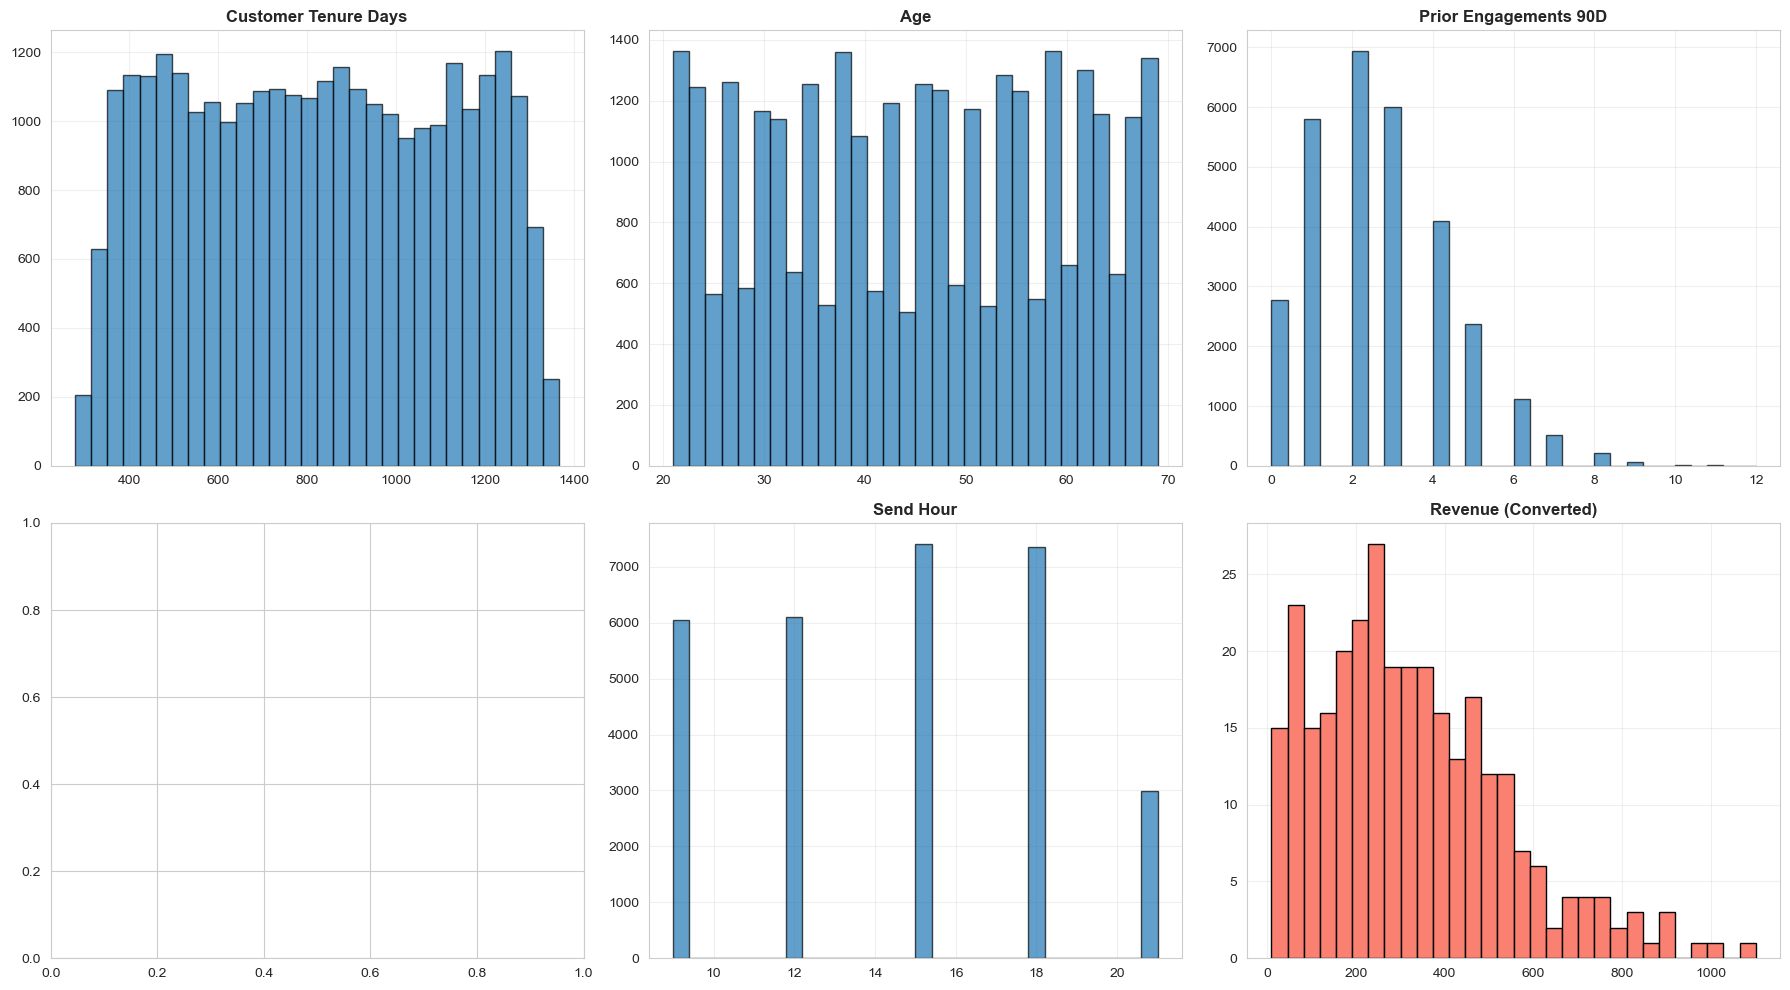


Top 10 features correlated with conversion:
hist_open_rate                0.005069
send_hour_afternoon           0.005060
age                           0.002227
campaign_age_days             0.001456
days_since_campaign_launch    0.001456
hist_total_opens              0.001212
send_hour                     0.001180
prior_engagements_90d         0.000935
send_hour_evening            -0.001469
send_is_weekend              -0.002638
Name: converted, dtype: float64


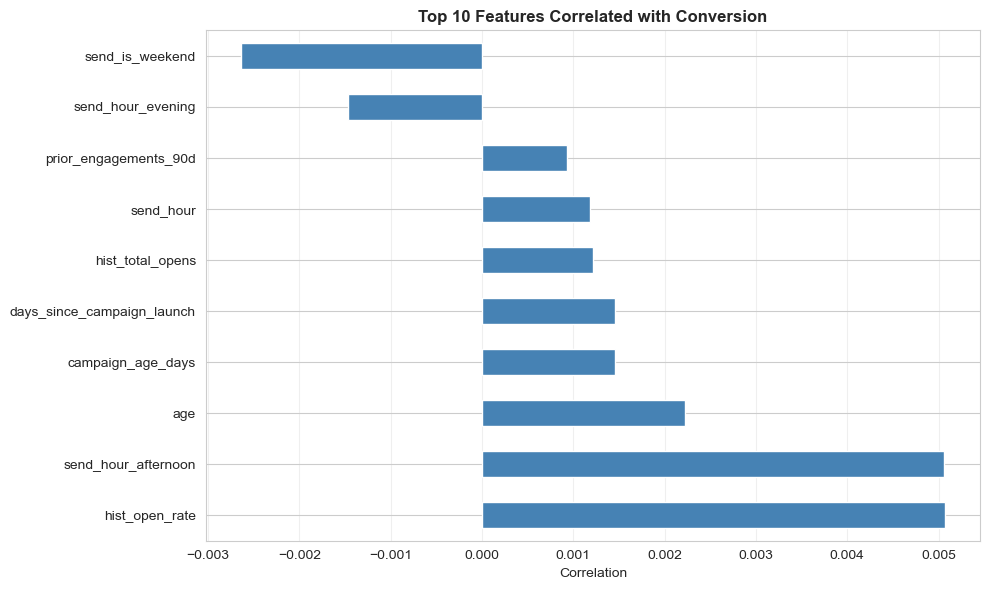

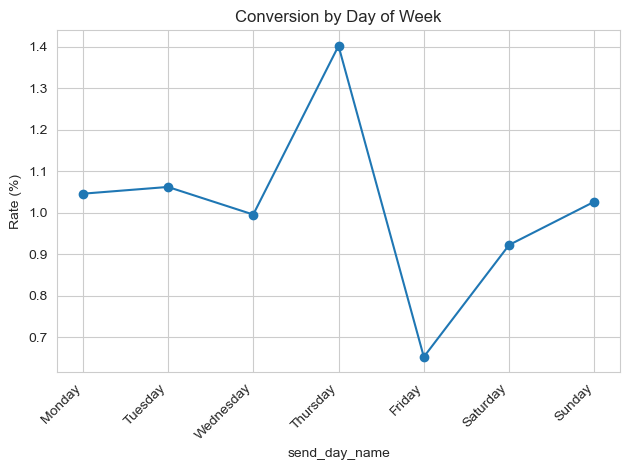


Top 5 hours: {15: 1.106164845541616, 18: 1.0341543067083956, 12: 1.0317720275139208, 9: 0.9263854425144747, 21: 0.9036144578313252}


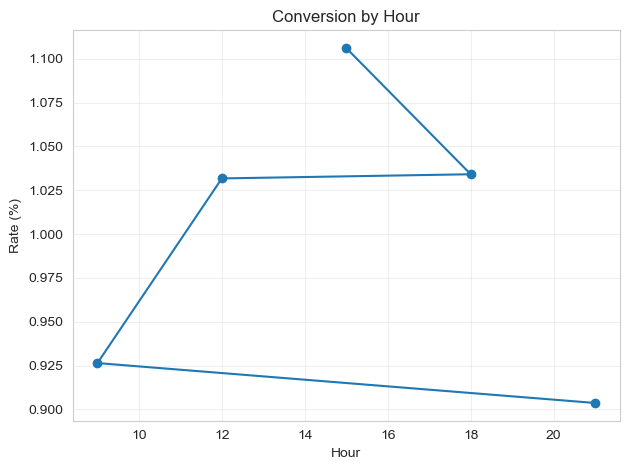


Funnel: {'Open': 31.891909969566235, 'Click': 6.718838834821578, 'Conversion': 1.0166884050700646}


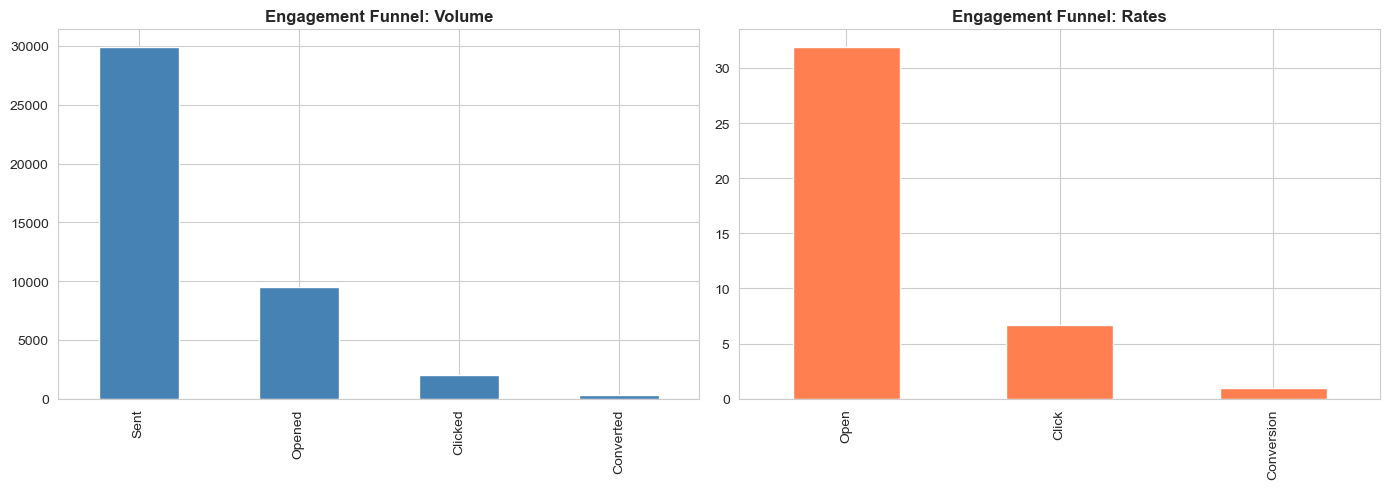


Overall conversion rate: 1.02%
Best tier: Gold (1.13%)
Best channel: App Push (1.21%)


In [9]:
eda_df = df.copy() if 'tier' in df.columns else modeling_df.copy()

def calc_rate(df, col):
    """Calculate conversion rate by column."""
    if col not in df.columns:
        return None
    result = df.groupby(col)['converted'].agg(['sum', 'count', 'mean'])
    result.columns = ['conversions', 'total', 'conversion_rate']
    result['rate_pct'] = result['conversion_rate'] * 100
    return result.sort_values('conversion_rate', ascending=False)

# Conversion rate by segments
segments = ['tier', 'channel', 'objective', 'region', 'device_type']
conv_results = {}
for seg in segments:
    result = calc_rate(eda_df, seg)
    if result is not None:
        conv_results[seg] = result
        print(f"\n{seg.title()} conversion rates:")
        print(result)

# Distribution analysis
dist_cols = ['customer_tenure_days', 'age', 'prior_engagements_90d', 
             'budget_per_customer', 'send_hour']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(dist_cols):
    if col in eda_df.columns:
        eda_df[col].hist(bins=30, ax=axes[i], edgecolor='black', alpha=0.7)
        axes[i].set_title(col.replace('_', ' ').title(), fontweight='bold')
        axes[i].grid(alpha=0.3)

# Revenue for converted only
if 'revenue_rm' in eda_df.columns:
    converted_revenue = eda_df[eda_df['converted'] == 1]['revenue_rm']
    if len(converted_revenue) > 0:
        converted_revenue.hist(bins=30, ax=axes[5], color='salmon', edgecolor='black')
        axes[5].set_title('Revenue (Converted)', fontweight='bold')
        axes[5].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
exclude = ['interaction_id', 'customer_id', 'campaign_id', 'opened', 'clicked', 
           'converted', 'revenue_rm']
corr_features = [c for c in eda_df.select_dtypes(include=[np.number]).columns 
                 if c not in exclude and 'converted' not in c]

if len(corr_features) > 0 and 'converted' in eda_df.columns:
    corr_with_target = eda_df[corr_features + ['converted']].corr()['converted'].sort_values(ascending=False)
    print(f"\nTop 10 features correlated with conversion:")
    print(corr_with_target[1:11])
    
    top_corr = corr_with_target[1:11]
    fig, ax = plt.subplots(figsize=(10, 6))
    top_corr.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Top 10 Features Correlated with Conversion', fontweight='bold')
    ax.set_xlabel('Correlation')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Temporal patterns
if 'send_day_name' in eda_df.columns:
    dow_conv = calc_rate(eda_df, 'send_day_name')
    if dow_conv is not None:
        dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        dow_conv_reordered = dow_conv.reindex([d for d in dow_order if d in dow_conv.index])
        dow_conv_reordered['rate_pct'].plot(kind='line', marker='o', title='Conversion by Day of Week', ylabel='Rate (%)')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

if 'send_hour' in eda_df.columns:
    hour_conv = calc_rate(eda_df, 'send_hour')
    if hour_conv is not None:
        print(f"\nTop 5 hours: {hour_conv.head(5)['rate_pct'].to_dict()}")
        hour_conv['rate_pct'].plot(kind='line', marker='o', title='Conversion by Hour', ylabel='Rate (%)', xlabel='Hour')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Engagement funnel
funnel = {
    'Sent': len(eda_df),
    'Opened': eda_df.get('opened', pd.Series()).sum(),
    'Clicked': eda_df.get('clicked', pd.Series()).sum(),
    'Converted': eda_df['converted'].sum()
}
rates = {k.replace(' Rate', ''): (v / funnel['Sent']) * 100 
         for k, v in [('Open', funnel['Opened']), ('Click', funnel['Clicked']), ('Conversion', funnel['Converted'])]}

print(f"\nFunnel: {rates}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pd.Series(funnel).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Engagement Funnel: Volume', fontweight='bold')
pd.Series(rates).plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Engagement Funnel: Rates', fontweight='bold')
plt.tight_layout()
plt.show()

# Summary
print(f"\nOverall conversion rate: {eda_df['converted'].mean():.2%}")
if 'tier' in conv_results:
    best_tier = conv_results['tier'].index[0]
    print(f"Best tier: {best_tier} ({conv_results['tier'].loc[best_tier, 'rate_pct']:.2f}%)")
if 'channel' in conv_results:
    best_channel = conv_results['channel'].index[0]
    print(f"Best channel: {best_channel} ({conv_results['channel'].loc[best_channel, 'rate_pct']:.2f}%)")

## Phase 2: Model Development & Evaluation

### 2.1 Data Preparation

Handles missing values, encodes categorical variables using one-hot encoding, selects and sanitizes feature columns for modeling, and separates features from the target variable. Also calculates class imbalance ratio to inform model training strategies.

In [10]:
from sklearn.preprocessing import StandardScaler
import pickle

# ✅ FIX: Use already-split dataframes from temporal split (Cell 10)
# Handle missing values for each split
for split_name, split_df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    if split_df.isnull().sum().sum() > 0:
        numeric_cols = split_df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if split_df[col].isnull().sum() > 0:
                split_df[col].fillna(split_df[col].median(), inplace=True)
        categorical_cols_obj = split_df.select_dtypes(include=['object']).columns
        for col in categorical_cols_obj:
            if split_df[col].isnull().sum() > 0:
                split_df[col].fillna(split_df[col].mode()[0] if len(split_df[col].mode()) > 0 else 'Unknown', inplace=True)

# Get categorical columns
exclude_from_encoding = ['interaction_id', 'customer_id', 'campaign_id', 
                         'campaign_name', 'send_date', 'launch_date', 
                         'relationship_start', 'month']
categorical_cols = [c for c in train_df.select_dtypes(include=['object']).columns 
                    if c not in exclude_from_encoding]

# Convert pd.cut columns to string
for col in ['age_group', 'tenure_group']:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype(str)
        val_df[col] = val_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)

# Encode each split separately
train_encoded = pd.get_dummies(train_df, columns=categorical_cols, prefix=categorical_cols, drop_first=True)
val_encoded = pd.get_dummies(val_df, columns=categorical_cols, prefix=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_df, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

# Ensure all splits have same columns (add missing columns with 0)
all_columns = sorted(set(train_encoded.columns) | set(val_encoded.columns) | set(test_encoded.columns))
for col in all_columns:
    if col not in train_encoded.columns:
        train_encoded[col] = 0
    if col not in val_encoded.columns:
        val_encoded[col] = 0
    if col not in test_encoded.columns:
        test_encoded[col] = 0

# Reorder columns to match
train_encoded = train_encoded[all_columns]
val_encoded = val_encoded[all_columns]
test_encoded = test_encoded[all_columns]

print(f"   ✓ Encoded categorical variables")
print(f"   Train shape: {train_encoded.shape}, Val shape: {val_encoded.shape}, Test shape: {test_encoded.shape}")

# Select features
exclude_features = [
    'interaction_id', 'customer_id', 'campaign_id', 'campaign_name',
    'send_date', 'launch_date', 'relationship_start', 'month',
    'converted', 'opened', 'clicked', 'revenue_rm',
    'has_revenue', 'open_to_click_rate', 'click_to_convert_rate',
    'hist_conversion_rate'  # ✅ FIX: Exclude target leakage feature
]

feature_columns = [c for c in train_encoded.columns if c not in exclude_features]
feature_columns = [c for c in feature_columns 
                   if train_encoded[c].dtype in ['int64', 'int32', 'float64', 'float32', 'uint8', 'bool']]

# Sanitize feature names for XGBoost
name_mapping = {}
for col in feature_columns:
    clean_name = col.replace('[', '_').replace(']', '_').replace('<', 'lt_').replace('>', 'gt_').replace('-', '_').replace(' ', '_')
    clean_name = clean_name.replace('__', '_').strip('_')
    if clean_name != col:
        name_mapping[col] = clean_name

if name_mapping:
    train_encoded = train_encoded.rename(columns=name_mapping)
    val_encoded = val_encoded.rename(columns=name_mapping)
    test_encoded = test_encoded.rename(columns=name_mapping)
    feature_columns = [name_mapping.get(c, c) for c in feature_columns]

# Separate features and target
X_train = train_encoded[feature_columns].copy()
y_train = train_encoded['converted'].copy()
X_val = val_encoded[feature_columns].copy()
y_val = val_encoded['converted'].copy()
X_test = test_encoded[feature_columns].copy()
y_test = test_encoded['converted'].copy()

# Ensure numeric types
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
    elif X_train[col].dtype == 'bool':
        X_train[col] = X_train[col].astype(int)

for col in X_val.columns:
    if X_val[col].dtype == 'object':
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce').fillna(0)
    elif X_val[col].dtype == 'bool':
        X_val[col] = X_val[col].astype(int)

for col in X_test.columns:
    if X_test[col].dtype == 'object':
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)
    elif X_test[col].dtype == 'bool':
        X_test[col] = X_test[col].astype(int)

# Class imbalance
class_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Features: {len(feature_columns)}, Class ratio: {class_ratio:.1f}:1")


   ✓ Encoded categorical variables
   Train shape: (20930, 60), Val shape: (4485, 60), Test shape: (4486, 60)
Features: 47, Class ratio: 93.7:1


#### Train-Validation-Test Split & Feature Scaling

Splits the data into training (70%), validation (15%), and test (15%) sets to maintain class distribution. Applies standard scaling to features for models that require normalised inputs.

In [11]:
print(f"Train: {X_train.shape[0]:,} ({X_train.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"Val: {X_val.shape[0]:,} ({X_val.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")
print(f"Test: {X_test.shape[0]:,} ({X_test.shape[0]/(X_train.shape[0]+X_val.shape[0]+X_test.shape[0])*100:.1f}%)")

# Feature scaling (fit on train only to prevent data leakage)
X_train = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_val = X_val.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print(f"\n Data preparation complete. Features: {len(feature_columns)}")


Train: 20,930 (70.0%)
Val: 4,485 (15.0%)
Test: 4,486 (15.0%)

 Data preparation complete. Features: 47


### 2.2 Model Training & Selection

Trains three baseline models (Logistic Regression, Random Forest, and XGBoost) with class balancing to handle the imbalanced dataset. Performs 5-fold cross-validation to assess model stability, conducts hyperparameter tuning via grid search on the best-performing model, and selects the final model based on validation performance. Includes comprehensive model comparison visualizations and performance metrics.


Training models...
Logistic Regression - Val AUC: 0.4917, F1: 0.0185
Random Forest - Val AUC: 0.5496, F1: 0.0212
Top 5 features: age, campaign_age_days, customer_tenure_days, customer_tenure_months, days_since_campaign_launch
XGBoost - Val AUC: 0.5611, F1: 0.0187
Top 5 features: channel_campaign_WhatsApp, region_Sabah/Sarawak, objective_Retention, hist_total_revenue, send_hour_afternoon

Model Performance:
                     train_auc  val_auc  val_precision  val_recall  val_f1  \
XGBoost                 0.9542   0.5611         0.0100      0.1429  0.0187   
Random Forest           0.8593   0.5496         0.0113      0.1667  0.0212   
Logistic Regression     0.6643   0.4917         0.0094      0.5238  0.0185   

                     training_time  
XGBoost                     0.0781  
Random Forest               0.3103  
Logistic Regression         2.0422  


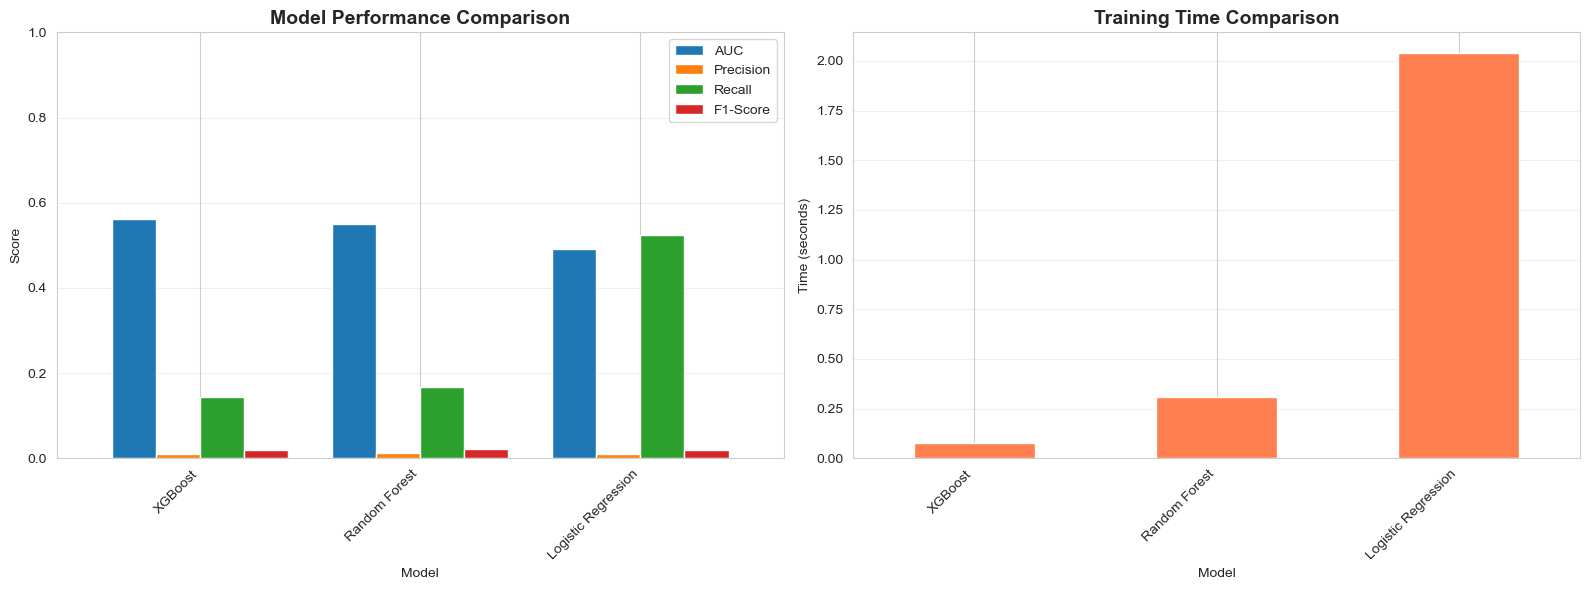


3. Temporal Cross-Validation Analysis...

   Logistic Regression:
     Temporal CV AUC: 0.5630 (+/- 0.0752)
     Individual fold scores: [0.54245228 0.58088137 0.55788711 0.51091234 0.62292633]

   Random Forest:
     Temporal CV AUC: 0.5436 (+/- 0.0701)
     Individual fold scores: [0.5517833  0.52734421 0.58940503 0.48600263 0.56347883]

   XGBoost:
     Temporal CV AUC: 0.5085 (+/- 0.1221)
     Individual fold scores: [0.4944091  0.48955649 0.55261632 0.41341344 0.59261891]


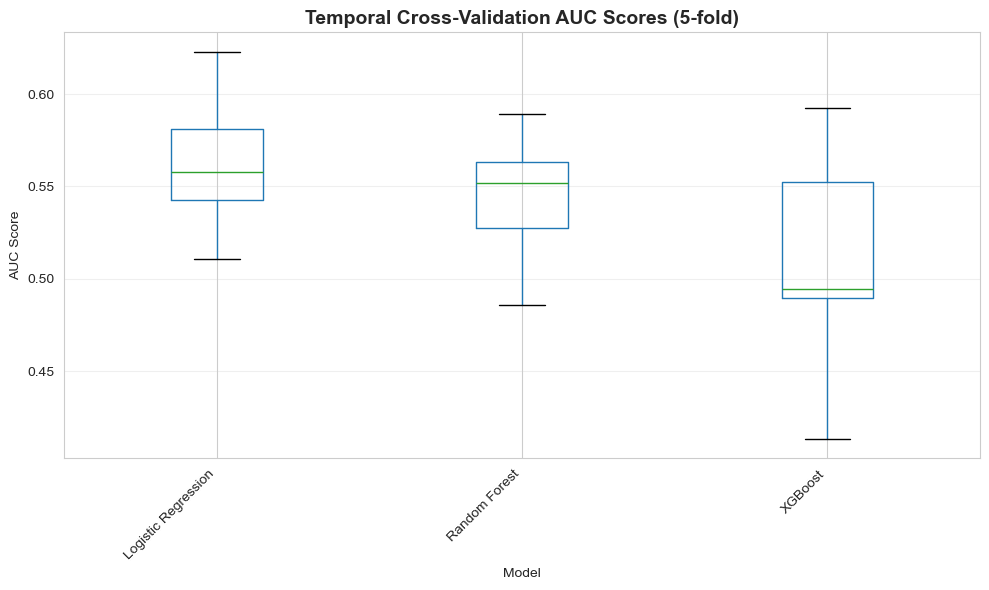


4. Hyperparameter Tuning...
   Tuning XGBoost (best performing model)...
   Performing Grid Search for XGBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
   Best parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.9}
   Best CV score: 0.5444
   Validation AUC (tuned): 0.5565

5. Selecting Final Model...
   Selected model: XGBoost_Tuned

   Final Model Performance (Validation Set):
     AUC: 0.5565
     Precision: 0.0126
     Recall: 0.1905
     F1: 0.0237

   Confusion Matrix:
                 Predicted
                 No    Yes
   Actual No    3817   626
          Yes     34     8

MODEL TRAINING SUMMARY
✓ Trained 3 baseline models: Logistic Regression, Random Forest, XGBoost
✓ Performed 5-fold cross-validation
✓ Hyperparameter tuning completed for best model
✓ Final model selected: XGBoost_Tuned
✓ Validation AUC: 0.5565

Ready for model evaluation and interpretation!


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve)
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import time

def train_and_evaluate_model(name, model, X_train_data, y_train_data, X_val_data, y_val_data):
    """Train and evaluate a model, returning results dictionary."""
    start_time = time.time()
    model.fit(X_train_data, y_train_data)
    
    y_train_proba = model.predict_proba(X_train_data)[:, 1]
    y_val_proba = model.predict_proba(X_val_data)[:, 1]
    y_val_pred = model.predict(X_val_data)
    
    return {
        'model': model,
        'train_auc': roc_auc_score(y_train_data, y_train_proba),
        'val_auc': roc_auc_score(y_val_data, y_val_proba),
        'val_precision': precision_score(y_val_data, y_val_pred),
        'val_recall': recall_score(y_val_data, y_val_pred),
        'val_f1': f1_score(y_val_data, y_val_pred),
        'training_time': time.time() - start_time
    }

models = {}
model_results = {}
class_ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Train models
print("Training models...")

# Logistic Regression
lr_result = train_and_evaluate_model(
    'Logistic Regression',
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42, solver='lbfgs', n_jobs=-1),
    X_train_scaled, y_train, X_val_scaled, y_val
)
models['Logistic Regression'] = lr_result['model']
model_results['Logistic Regression'] = {k: v for k, v in lr_result.items() if k != 'model'}
print(f"Logistic Regression - Val AUC: {lr_result['val_auc']:.4f}, F1: {lr_result['val_f1']:.4f}")

# Random Forest
# ✅ FIX: Increased regularization to prevent overfitting
rf_result = train_and_evaluate_model(
    'Random Forest',
    RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=50, 
                          min_samples_leaf=20, max_features='sqrt', class_weight='balanced', 
                          random_state=42, n_jobs=-1, verbose=0),
    X_train, y_train, X_val, y_val
)
models['Random Forest'] = rf_result['model']
model_results['Random Forest'] = {k: v for k, v in rf_result.items() if k != 'model'}

feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_result['model'].feature_importances_
}).sort_values('importance', ascending=False)
print(f"Random Forest - Val AUC: {rf_result['val_auc']:.4f}, F1: {rf_result['val_f1']:.4f}")
print(f"Top 5 features: {', '.join(feature_importance_rf.head(5)['feature'].tolist())}")

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, scale_pos_weight=class_ratio,
    random_state=42, n_jobs=-1, eval_metric='auc', verbosity=0, early_stopping_rounds=10
)
start_time = time.time()
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred_xgb = xgb_model.predict(X_val)

xgb_result = {
    'model': xgb_model,
    'train_auc': roc_auc_score(y_train, y_train_proba_xgb),
    'val_auc': roc_auc_score(y_val, y_val_proba_xgb),
    'val_precision': precision_score(y_val, y_val_pred_xgb),
    'val_recall': recall_score(y_val, y_val_pred_xgb),
    'val_f1': f1_score(y_val, y_val_pred_xgb),
    'training_time': time.time() - start_time
}
models['XGBoost'] = xgb_result['model']
model_results['XGBoost'] = {k: v for k, v in xgb_result.items() if k != 'model'}

feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print(f"XGBoost - Val AUC: {xgb_result['val_auc']:.4f}, F1: {xgb_result['val_f1']:.4f}")
print(f"Top 5 features: {', '.join(feature_importance_xgb.head(5)['feature'].tolist())}")

# Model comparison
results_df = pd.DataFrame(model_results).T.sort_values('val_auc', ascending=False)
print(f"\nModel Performance:\n{results_df.round(4)}")

# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics = ['val_auc', 'val_precision', 'val_recall', 'val_f1']
results_df[metrics].plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(['AUC', 'Precision', 'Recall', 'F1-Score'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Training time comparison
results_df['training_time'].plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Cross-validation
print("\n3. Temporal Cross-Validation Analysis...")

from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import clone

# ✅ FIX: Use temporal cross-validation instead of random splits
# This respects temporal ordering and prevents data leakage
cv = TimeSeriesSplit(n_splits=5)
cv_results = {}

for name, model in models.items():
    print(f"\n   {name}:")
    
    # Use scaled data for Logistic Regression, original for tree-based
    X_cv = X_train_scaled if name == 'Logistic Regression' else X_train
    model_cv = model
    
    # Clone model and remove early_stopping for XGBoost
    if name == 'XGBoost':
        # Get model parameters and create new one without early_stopping
        model_cv = xgb.XGBClassifier(**model.get_params())
        # Remove early_stopping_rounds if it exists
        if hasattr(model_cv, 'early_stopping_rounds'):
            model_cv.set_params(early_stopping_rounds=None)
    else:
        model_cv = clone(model)
        
    # Perform cross-validation
    cv_scores = cross_val_score(
        model_cv, X_cv, y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"     Temporal CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"     Individual fold scores: {cv_scores}")

# Visualize CV results
cv_df = pd.DataFrame({k: v['scores'] for k, v in cv_results.items()})
fig, ax = plt.subplots(figsize=(10, 6))
cv_df.boxplot(ax=ax)
ax.set_title('Temporal Cross-Validation AUC Scores (5-fold)', fontsize=14, fontweight='bold')
ax.set_ylabel('AUC Score')
ax.set_xlabel('Model')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Hyperparameter tuning
print("\n4. Hyperparameter Tuning...")

# Select best model based on validation AUC
best_model_name = results_df.index[0]
print(f"   Tuning {best_model_name} (best performing model)...")

if best_model_name == 'XGBoost':
    print("   Performing Grid Search for XGBoost...")
    
    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }
    
    # Base model
    xgb_base = xgb.XGBClassifier(
        scale_pos_weight=class_ratio,
        random_state=42,
        n_jobs=-1,
        eval_metric='auc',
        verbosity=0
    )
    
    # Grid search with 3-fold CV (to save time)
    grid_search = GridSearchCV(
        xgb_base,
        param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best CV score: {grid_search.best_score_:.4f}")
    
    # Use best model
    best_model = grid_search.best_estimator_
    models['XGBoost_Tuned'] = best_model
    
    # Evaluate tuned model
    y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]
    val_auc_tuned = roc_auc_score(y_val, y_val_proba_tuned)
    print(f"   Validation AUC (tuned): {val_auc_tuned:.4f}")
    
elif best_model_name == 'Random Forest':
    print("   Performing Grid Search for Random Forest...")
    
    # ✅ FIX: Increased regularization in grid search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [4, 5, 6],
        'min_samples_split': [30, 50]
    }
    
    rf_base = RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    grid_search = GridSearchCV(
        rf_base,
        param_grid,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best CV score: {grid_search.best_score_:.4f}")
    
    best_model = grid_search.best_estimator_
    models['Random Forest_Tuned'] = best_model
    
    y_val_proba_tuned = best_model.predict_proba(X_val)[:, 1]
    val_auc_tuned = roc_auc_score(y_val, y_val_proba_tuned)
    print(f"   Validation AUC (tuned): {val_auc_tuned:.4f}")

# Select final model
print("\n5. Selecting Final Model...")

# Determine final model (use tuned if available, otherwise best baseline)
if 'XGBoost_Tuned' in models:
    final_model = models['XGBoost_Tuned']
    final_model_name = 'XGBoost_Tuned'
    use_scaled = False
elif 'Random Forest_Tuned' in models:
    final_model = models['Random Forest_Tuned']
    final_model_name = 'Random Forest_Tuned'
    use_scaled = False
else:
    final_model = models[best_model_name]
    final_model_name = best_model_name
    use_scaled = (best_model_name == 'Logistic Regression')

print(f"   Selected model: {final_model_name}")

# Final evaluation on validation set
X_final_val = X_val_scaled if use_scaled else X_val
y_val_pred_final = final_model.predict(X_final_val)
y_val_proba_final = final_model.predict_proba(X_final_val)[:, 1]

final_metrics = {
    'AUC': roc_auc_score(y_val, y_val_proba_final),
    'Precision': precision_score(y_val, y_val_pred_final),
    'Recall': recall_score(y_val, y_val_pred_final),
    'F1': f1_score(y_val, y_val_pred_final)
}

print(f"\n   Final Model Performance (Validation Set):")
for metric, value in final_metrics.items():
    print(f"     {metric}: {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_final)
print(f"\n   Confusion Matrix:")
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"   Actual No   {cm[0,0]:5d} {cm[0,1]:5d}")
print(f"          Yes  {cm[1,0]:5d} {cm[1,1]:5d}")

# Summary
print("\n" + "=" * 60)
print("MODEL TRAINING SUMMARY")
print("=" * 60)
print(f"✓ Trained 3 baseline models: Logistic Regression, Random Forest, XGBoost")
print(f"✓ Performed 5-fold cross-validation")
print(f"✓ Hyperparameter tuning completed for best model")
print(f"✓ Final model selected: {final_model_name}")
print(f"✓ Validation AUC: {final_metrics['AUC']:.4f}")
print("\nReady for model evaluation and interpretation!")
print("=" * 80)

### 2.3 Model Evaluation

Evaluates the final model on the test set with comprehensive metrics including AUC-ROC, precision, recall, F1-score, and average precision. Compares performance across train, validation, and test sets to assess generalization. Includes ROC curve analysis, precision-recall curve analysis, and threshold optimization to find the optimal classification threshold.



1. Final Model Evaluation on Test Set...

   Test Set Performance:
     AUC-ROC: 0.5180
     Precision: 0.0131
     Recall: 0.1220
     F1-Score: 0.0236
     Average Precision: 0.0124

   Confusion Matrix (Test Set):
                 Predicted
                 No    Yes
   Actual No    4067   378
          Yes     36     5

   Classification Report (Test Set):
               precision    recall  f1-score   support

Not Converted       0.99      0.91      0.95      4445
    Converted       0.01      0.12      0.02        41

     accuracy                           0.91      4486
    macro avg       0.50      0.52      0.49      4486
 weighted avg       0.98      0.91      0.94      4486


2. Model Performance: Train vs Validation vs Test...

   Performance Comparison:
               AUC  Precision  Recall      F1
Train       0.9408     0.0445  0.9502  0.0850
Validation  0.5565     0.0126  0.1905  0.0237
Test        0.5180     0.0131  0.1220  0.0236


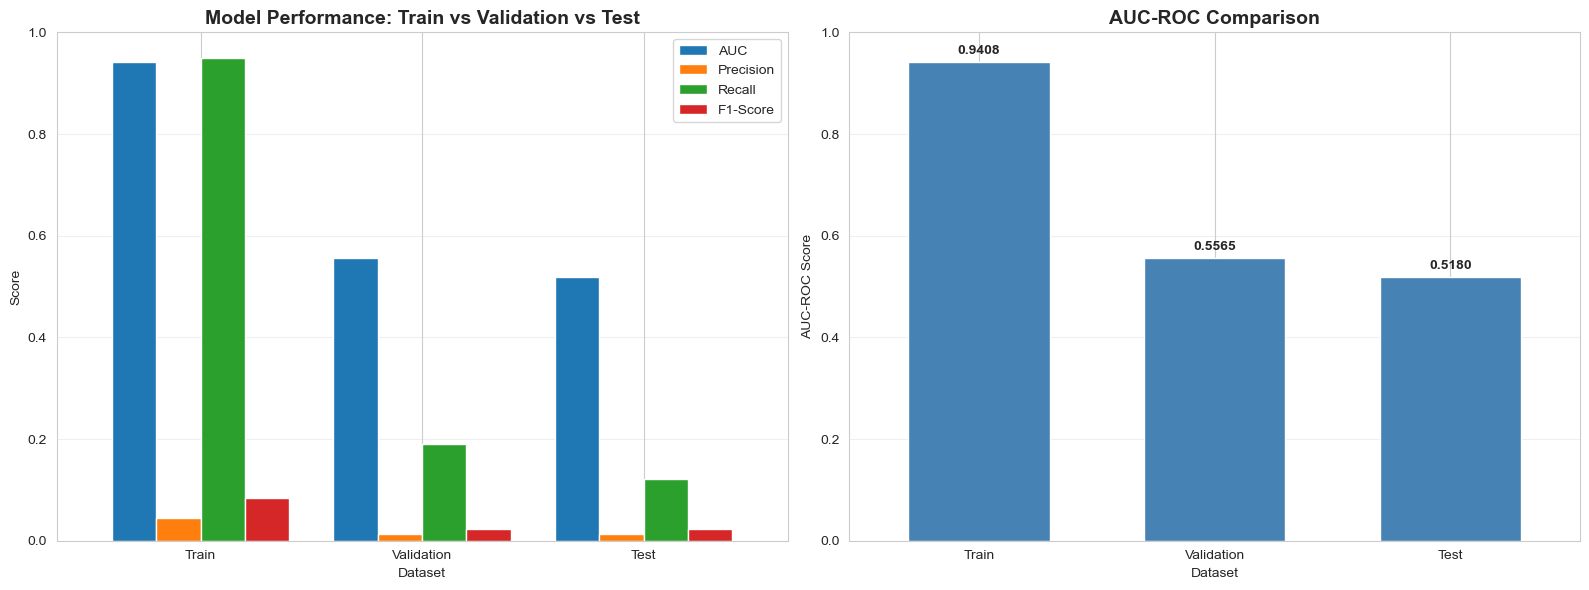


   Overfitting Analysis:
     Train AUC: 0.9408
     Test AUC: 0.5180
     AUC Gap: 0.4229
     ⚠️  Potential overfitting detected (gap > 0.1)

3. ROC Curve Analysis...


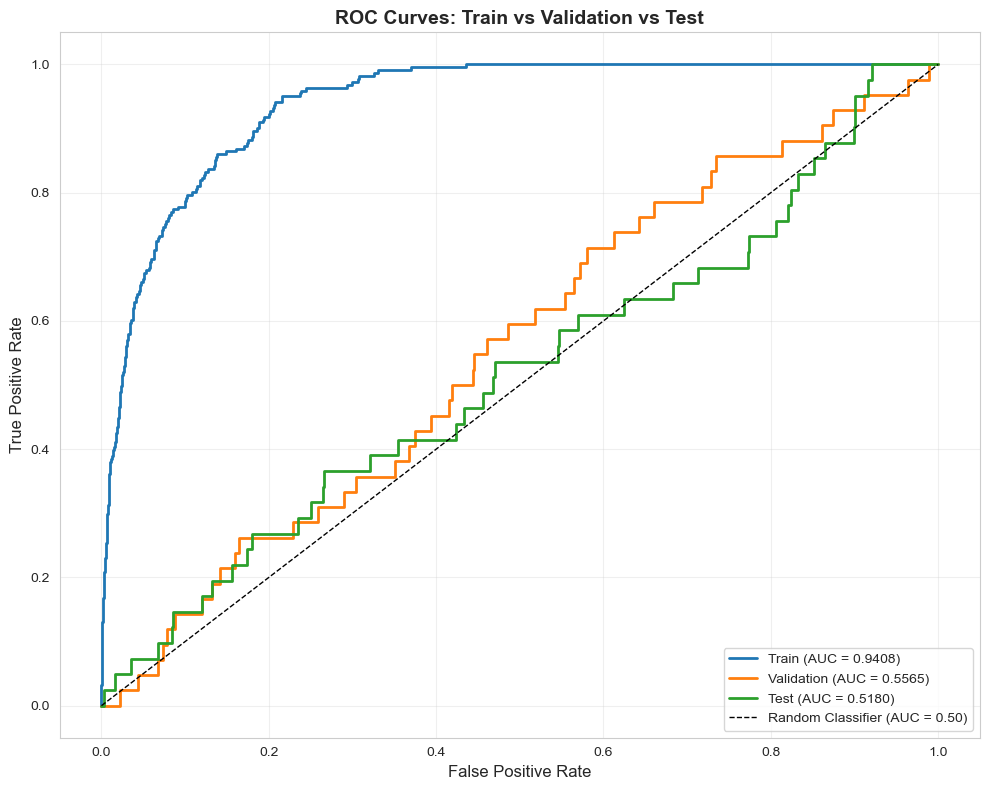


4. Precision-Recall Curve Analysis...


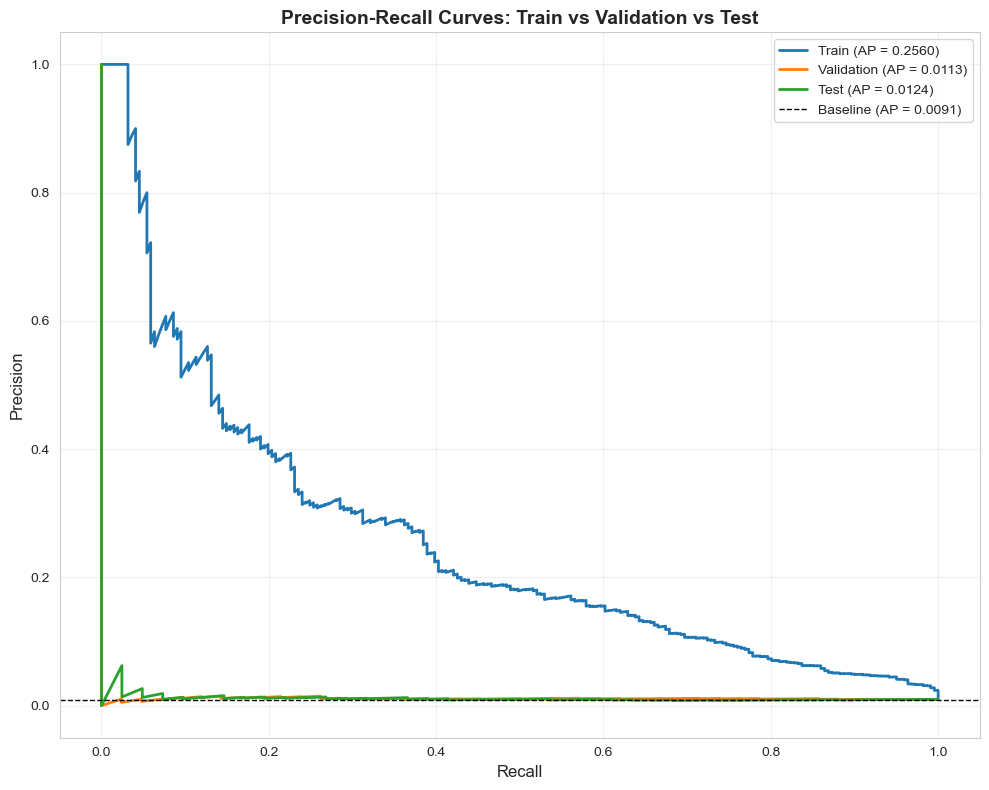


5. Threshold Analysis...
   Optimal threshold (F1-score): 0.700
   F1-score at optimal threshold: 0.0351
   Precision at optimal threshold: 0.0625
   Recall at optimal threshold: 0.0244


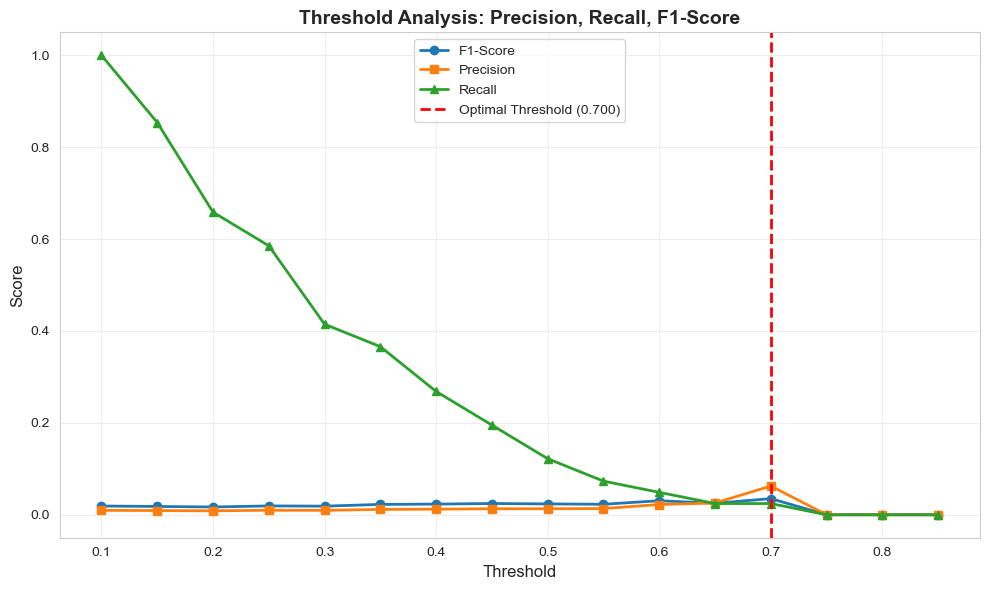


   Performance with Optimal Threshold (0.700):
     Precision: 0.0625
     Recall: 0.0244
     F1-Score: 0.0351

6. Probability Calibration Analysis...


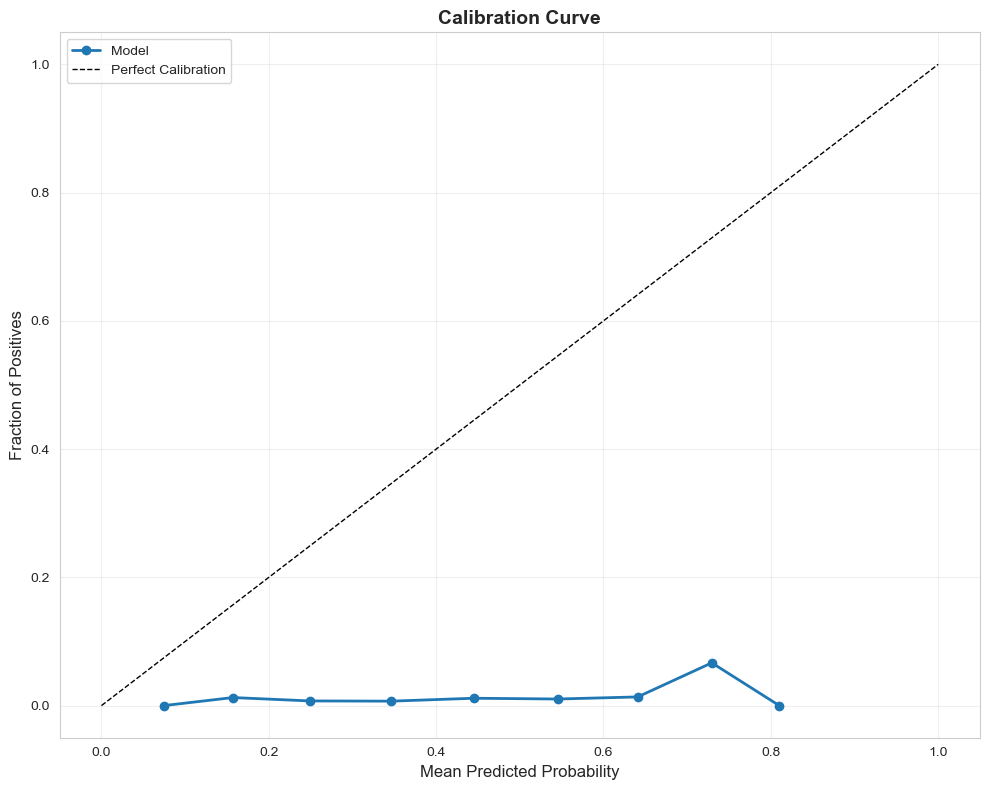

   Brier Score: 0.1043 (lower is better, 0 = perfect)
   Mean Calibration Error: 0.4299
   ⚠️  Significant miscalibration detected (error > 0.05)
   Recommendation: Apply calibration (Platt scaling or Isotonic regression)
   Applying isotonic calibration...
   Calibrated Brier Score: 0.0091
   Calibrated Mean Error: 0.0553


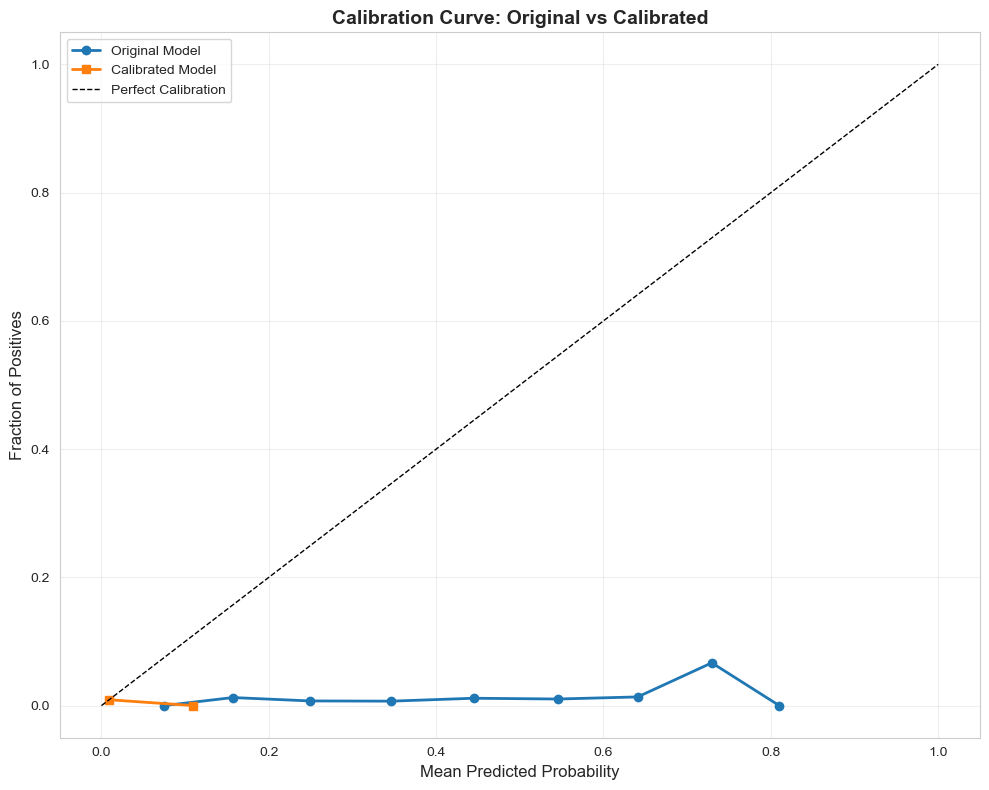


   Calibrated Model Performance:
     AUC-ROC: 0.5293
     Precision: 0.0000
     Recall: 0.0000
     F1-Score: 0.0000
     Average Precision: 0.0140

MODEL EVALUATION SUMMARY
Final Model: XGBoost_Tuned
Test Set Performance:
  - AUC-ROC: 0.5180
  - Precision: 0.0131
  - Recall: 0.1220
  - F1-Score: 0.0236
  - Average Precision: 0.0124
  - Brier Score: 0.1043

Overfitting Check: AUC Gap = 0.4229
Optimal Threshold: 0.700


In [13]:
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, precision_recall_curve, average_precision_score)

# Final model evaluation on test set
print("\n1. Final Model Evaluation on Test Set...")

# Use appropriate data (scaled for Logistic Regression, original for tree-based)
X_final_test = X_test_scaled if use_scaled else X_test

# Get predictions and probabilities
y_test_pred = final_model.predict(X_final_test)
y_test_proba = final_model.predict_proba(X_final_test)[:, 1]

# Calculate metrics
test_metrics = {
    'AUC-ROC': roc_auc_score(y_test, y_test_proba),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-Score': f1_score(y_test, y_test_pred),
    'Average Precision': average_precision_score(y_test, y_test_proba)
}

print(f"\n   Test Set Performance:")
for metric, value in test_metrics.items():
    print(f"     {metric}: {value:.4f}")

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"\n   Confusion Matrix (Test Set):")
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"   Actual No   {cm_test[0,0]:5d} {cm_test[0,1]:5d}")
print(f"          Yes  {cm_test[1,0]:5d} {cm_test[1,1]:5d}")

# Classification Report
print(f"\n   Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Not Converted', 'Converted']))

# Comparison: Train vs Validation vs Test
print("\n2. Model Performance: Train vs Validation vs Test...")

# Get predictions for all sets
X_final_train = X_train_scaled if use_scaled else X_train
y_train_pred = final_model.predict(X_final_train)
y_train_proba = final_model.predict_proba(X_final_train)[:, 1]

y_val_pred = final_model.predict(X_final_val)
y_val_proba = final_model.predict_proba(X_final_val)[:, 1]

# Calculate metrics for all sets
performance_comparison = {
    'Train': {
        'AUC': roc_auc_score(y_train, y_train_proba),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1': f1_score(y_train, y_train_pred)
    },
    'Validation': {
        'AUC': roc_auc_score(y_val, y_val_proba),
        'Precision': precision_score(y_val, y_val_pred),
        'Recall': recall_score(y_val, y_val_pred),
        'F1': f1_score(y_val, y_val_pred)
    },
    'Test': {
        'AUC': roc_auc_score(y_test, y_test_proba),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1': f1_score(y_test, y_test_pred)
    }
}

# Create comparison dataframe
comparison_df = pd.DataFrame(performance_comparison).T
print("\n   Performance Comparison:")
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
comparison_df.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Model Performance: Train vs Validation vs Test', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Dataset')
axes[0].legend(['AUC', 'Precision', 'Recall', 'F1-Score'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)

# AUC comparison
auc_comparison = pd.DataFrame({
    'AUC': [performance_comparison['Train']['AUC'], 
            performance_comparison['Validation']['AUC'],
            performance_comparison['Test']['AUC']]
}, index=['Train', 'Validation', 'Test'])

auc_comparison.plot(kind='bar', ax=axes[1], color='steelblue', legend=False, width=0.6)
axes[1].set_title('AUC-ROC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AUC-ROC Score')
axes[1].set_xlabel('Dataset')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])
for i, v in enumerate(auc_comparison['AUC']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Check for overfitting
train_auc = performance_comparison['Train']['AUC']
test_auc = performance_comparison['Test']['AUC']
auc_gap = train_auc - test_auc

print(f"\n   Overfitting Analysis:")
print(f"     Train AUC: {train_auc:.4f}")
print(f"     Test AUC: {test_auc:.4f}")
print(f"     AUC Gap: {auc_gap:.4f}")
if auc_gap > 0.1:
    print(f"     ⚠️  Potential overfitting detected (gap > 0.1)")
elif auc_gap > 0.05:
    print(f"     ⚠️  Moderate overfitting (gap > 0.05)")
else:
    print(f"     ✓ Good generalization (gap <= 0.05)")

# ROC curve analysis
print("\n3. ROC Curve Analysis...")

# Calculate ROC curves for all sets
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr_train, tpr_train, label=f'Train (AUC = {performance_comparison["Train"]["AUC"]:.4f})', linewidth=2)
ax.plot(fpr_val, tpr_val, label=f'Validation (AUC = {performance_comparison["Validation"]["AUC"]:.4f})', linewidth=2)
ax.plot(fpr_test, tpr_test, label=f'Test (AUC = {performance_comparison["Test"]["AUC"]:.4f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Train vs Validation vs Test', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-recall curve analysis
print("\n4. Precision-Recall Curve Analysis...")

# Calculate PR curves
precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

# Plot PR curves
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(recall_train, precision_train, label=f'Train (AP = {average_precision_score(y_train, y_train_proba):.4f})', linewidth=2)
ax.plot(recall_val, precision_val, label=f'Validation (AP = {average_precision_score(y_val, y_val_proba):.4f})', linewidth=2)
ax.plot(recall_test, precision_test, label=f'Test (AP = {average_precision_score(y_test, y_test_proba):.4f})', linewidth=2)

# Baseline (random classifier)
baseline = (y_test == 1).mean()
ax.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline (AP = {baseline:.4f})', linewidth=1)

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves: Train vs Validation vs Test', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Threshold analysis
print("\n5. Threshold Analysis...")

# Find optimal threshold using F1-score
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_thresh = (y_test_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"   Optimal threshold (F1-score): {optimal_threshold:.3f}")
print(f"   F1-score at optimal threshold: {f1_scores[optimal_idx]:.4f}")
print(f"   Precision at optimal threshold: {precisions[optimal_idx]:.4f}")
print(f"   Recall at optimal threshold: {recalls[optimal_idx]:.4f}")

# Plot threshold analysis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, marker='o')
ax.plot(thresholds, precisions, label='Precision', linewidth=2, marker='s')
ax.plot(thresholds, recalls, label='Recall', linewidth=2, marker='^')
ax.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})', linewidth=2)
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Threshold Analysis: Precision, Recall, F1-Score', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evaluate with optimal threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)
print(f"\n   Performance with Optimal Threshold ({optimal_threshold:.3f}):")
print(f"     Precision: {precision_score(y_test, y_test_pred_optimal):.4f}")
print(f"     Recall: {recall_score(y_test, y_test_pred_optimal):.4f}")
print(f"     F1-Score: {f1_score(y_test, y_test_pred_optimal):.4f}")

# Probability Calibration Analysis
print("\n6. Probability Calibration Analysis...")

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)

# Plot calibration curve
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(prob_pred, prob_true, marker='o', label='Model', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)
ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Curve', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Brier score (lower is better, 0 = perfect)
brier = brier_score_loss(y_test, y_test_proba)
print(f"   Brier Score: {brier:.4f} (lower is better, 0 = perfect)")

# Check if calibration is needed
calibration_error = np.abs(prob_true - prob_pred).mean()
print(f"   Mean Calibration Error: {calibration_error:.4f}")
if calibration_error > 0.05:
    print(f"   ⚠️  Significant miscalibration detected (error > 0.05)")
    print(f"   Recommendation: Apply calibration (Platt scaling or Isotonic regression)")
    
    # Apply calibration
    from sklearn.calibration import CalibratedClassifierCV
    print(f"   Applying isotonic calibration...")
    calibrated_model = CalibratedClassifierCV(final_model, method='isotonic', cv=3)
    calibrated_model.fit(X_final_val, y_val)
    y_test_proba_cal = calibrated_model.predict_proba(X_final_test)[:, 1]
    
    # Re-evaluate calibrated model
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_test_proba_cal, n_bins=10)
    brier_cal = brier_score_loss(y_test, y_test_proba_cal)
    calibration_error_cal = np.abs(prob_true_cal - prob_pred_cal).mean()
    
    print(f"   Calibrated Brier Score: {brier_cal:.4f}")
    print(f"   Calibrated Mean Error: {calibration_error_cal:.4f}")
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(prob_pred, prob_true, marker='o', label='Original Model', linewidth=2)
    ax.plot(prob_pred_cal, prob_true_cal, marker='s', label='Calibrated Model', linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)
    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Fraction of Positives', fontsize=12)
    ax.set_title('Calibration Curve: Original vs Calibrated', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Update final model and probabilities
    # Store base model for feature importance (before calibration)
    base_model_for_importance = final_model
    
    # Update final model and probabilities
    final_model = calibrated_model
    y_test_proba = y_test_proba_cal
    y_test_pred = (y_test_proba >= optimal_threshold).astype(int)
    
    # Recalculate metrics with calibrated model
    test_metrics_cal = {
        'AUC-ROC': roc_auc_score(y_test, y_test_proba),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-Score': f1_score(y_test, y_test_pred),
        'Average Precision': average_precision_score(y_test, y_test_proba)
    }
    
    print(f"\n   Calibrated Model Performance:")
    for metric, value in test_metrics_cal.items():
        print(f"     {metric}: {value:.4f}")
else:
    print(f"   ✓ Model is well-calibrated (error <= 0.05)")

# Summary
print("\n" + "=" * 60)
print("MODEL EVALUATION SUMMARY")
print("=" * 60)
print(f"Final Model: {final_model_name}")
print(f"Test Set Performance:")
print(f"  - AUC-ROC: {test_metrics['AUC-ROC']:.4f}")
print(f"  - Precision: {test_metrics['Precision']:.4f}")
print(f"  - Recall: {test_metrics['Recall']:.4f}")
print(f"  - F1-Score: {test_metrics['F1-Score']:.4f}")
print(f"  - Average Precision: {test_metrics['Average Precision']:.4f}")
print(f"  - Brier Score: {brier:.4f}")
print(f"\nOverfitting Check: AUC Gap = {auc_gap:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print("=" * 60)

### 2.4 Model Interpretation

Analyses feature importance to identify the most predictive features. Computes SHAP values for model explainability, generates partial dependence plots for top features, and compares feature importance across different models. Provides business interpretation of key predictive features to understand what drives conversion.


1. Feature Importance Analysis...
   ⚠️  Model type not recognized. Cannot compute feature importance.
   ⚠️  Cannot visualize features - feature importance not available.

3. SHAP Values Analysis...
   Computing SHAP values for 1000 samples...
   ⚠️  SHAP analysis failed: Model type not yet supported by TreeExplainer: <class 'sklearn.calibration.CalibratedClassifierCV'>
   Continuing with other interpretation methods...

4. Partial Dependence Analysis...
   ⚠️  Cannot generate partial dependence plots - feature importance not available.

5. Feature Importance Comparison Across Models...

   Top 10 Features Comparison:


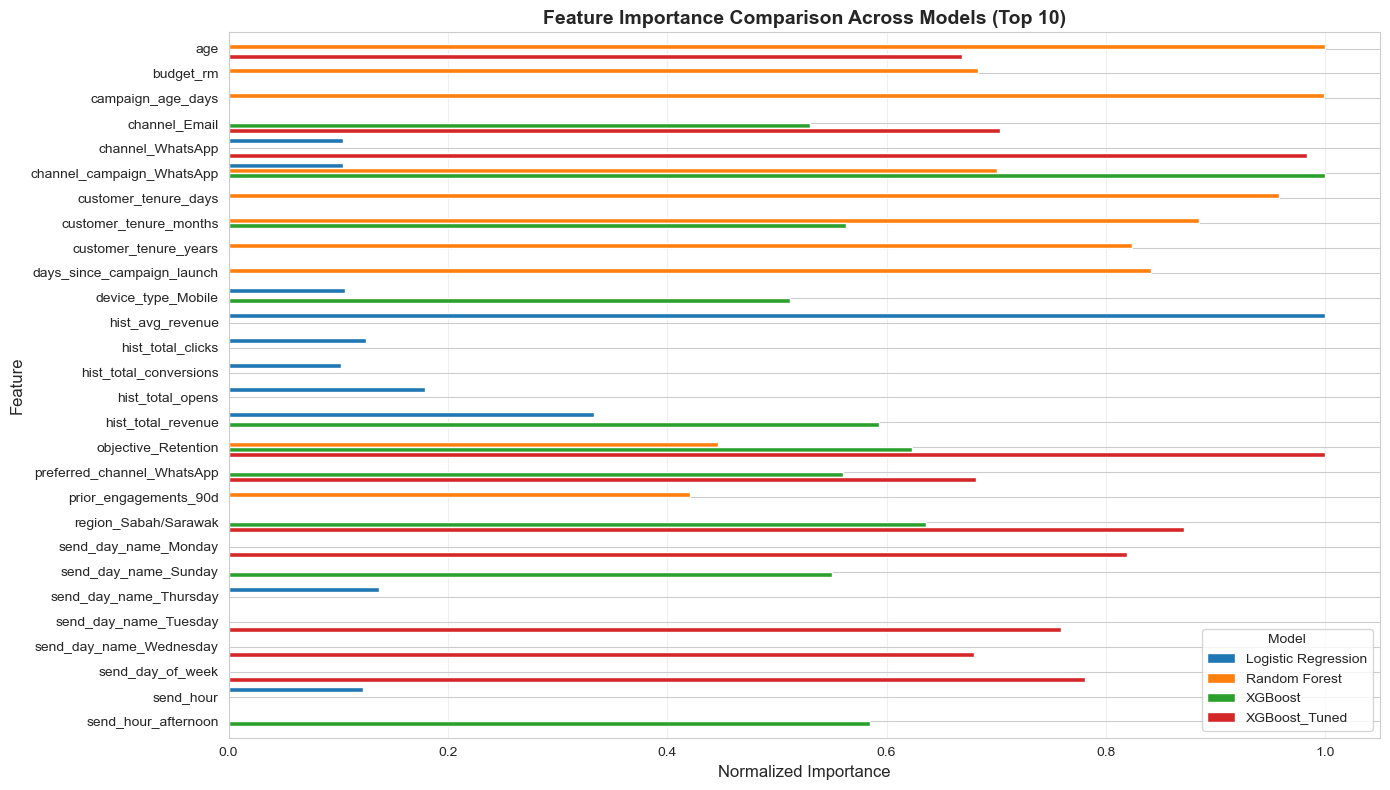


6. Business Interpretation of Top Features...

MODEL INTERPRETATION SUMMARY
Feature importance not available for this model type.

Key Insights:
  - Feature importance analysis reveals which customer/campaign attributes
    are most predictive of conversion
  - SHAP values provide local and global explanations for model predictions
  - Partial dependence plots show how individual features affect predictions


In [ ]:
import shap# Feature importanceprint("\n1. Feature Importance Analysis...")# Get feature importance based on model type# Handle CalibratedClassifierCV and GridSearchCV wrapped modelsmodel_to_check = final_model# Priority 1: Use stored base model (most reliable)if 'base_model_for_importance' in locals():    model_to_check = base_model_for_importance    print("   ℹ️  Using base model stored before calibration")    # Unwrap GridSearchCV if present    if hasattr(model_to_check, 'best_estimator_'):        model_to_check = model_to_check.best_estimator_        print("   ℹ️  Unwrapping GridSearchCV to access best estimator")# Priority 2: Try to unwrap CalibratedClassifierCV directlyelif 'CalibratedClassifierCV' in str(type(final_model)):    # Try multiple ways to access the base estimator    if hasattr(final_model, 'base_estimator'):        model_to_check = final_model.base_estimator        print("   ℹ️  Unwrapping CalibratedClassifierCV (via base_estimator)")    elif hasattr(final_model, 'estimator'):        model_to_check = final_model.estimator        print("   ℹ️  Unwrapping CalibratedClassifierCV (via estimator)")    elif hasattr(final_model, 'calibrated_classifiers_') and len(final_model.calibrated_classifiers_) > 0:        # Access through calibrated classifiers        if hasattr(final_model.calibrated_classifiers_[0], 'base_estimator'):            model_to_check = final_model.calibrated_classifiers_[0].base_estimator            print("   ℹ️  Unwrapping CalibratedClassifierCV (via calibrated_classifiers_)")        # Handle GridSearchCV wrapped models    if hasattr(model_to_check, 'best_estimator_'):        model_to_check = model_to_check.best_estimator_        print("   ℹ️  Unwrapping GridSearchCV to access best estimator")# Priority 3: Handle GridSearchCV only (if not CalibratedClassifierCV)elif hasattr(final_model, 'best_estimator_'):    model_to_check = final_model.best_estimator_    print("   ℹ️  Unwrapping GridSearchCV to access best estimator")# Get feature importance based on model type# Handle CalibratedClassifierCV and GridSearchCV wrapped modelsmodel_to_check = final_model# Priority 1: Use stored base model (most reliable)if 'base_model_for_importance' in locals():    model_to_check = base_model_for_importance    print("   ℹ️  Using base model stored before calibration")    # Unwrap GridSearchCV if present    if hasattr(model_to_check, 'best_estimator_'):        model_to_check = model_to_check.best_estimator_        print("   ℹ️  Unwrapping GridSearchCV to access best estimator")# Priority 2: Try to unwrap CalibratedClassifierCV directlyelif 'CalibratedClassifierCV' in str(type(final_model)):    # Try multiple ways to access the base estimator    if hasattr(final_model, 'base_estimator'):        model_to_check = final_model.base_estimator        print("   ℹ️  Unwrapping CalibratedClassifierCV (via base_estimator)")    elif hasattr(final_model, 'estimator'):        model_to_check = final_model.estimator        print("   ℹ️  Unwrapping CalibratedClassifierCV (via estimator)")    elif hasattr(final_model, 'calibrated_classifiers_') and len(final_model.calibrated_classifiers_) > 0:        # Access through calibrated classifiers        if hasattr(final_model.calibrated_classifiers_[0], 'base_estimator'):            model_to_check = final_model.calibrated_classifiers_[0].base_estimator            print("   ℹ️  Unwrapping CalibratedClassifierCV (via calibrated_classifiers_)")        # Handle GridSearchCV wrapped models    if hasattr(model_to_check, 'best_estimator_'):        model_to_check = model_to_check.best_estimator_        print("   ℹ️  Unwrapping GridSearchCV to access best estimator")# Priority 3: Handle GridSearchCV only (if not CalibratedClassifierCV)elif hasattr(final_model, 'best_estimator_'):    model_to_check = final_model.best_estimator_    print("   ℹ️  Unwrapping GridSearchCV to access best estimator")feature_importance = Noneif hasattr(model_to_check, 'feature_importances_'):    # Tree-based models (Random Forest, XGBoost)    # Use appropriate feature set based on whether model uses scaled data    feature_set = X_train_scaled.columns if use_scaled else X_train.columns    feature_importance = pd.DataFrame({        'feature': feature_set,        'importance': model_to_check.feature_importances_    }).sort_values('importance', ascending=False)        print(f"\n   Top 20 Most Important Features:")    print(feature_importance.head(20).to_string(index=False))    elif hasattr(model_to_check, 'coef_'):    # Linear models (Logistic Regression)    # Use absolute coefficients as importance    feature_importance = pd.DataFrame({        'feature': X_train_scaled.columns,        'importance': np.abs(model_to_check.coef_[0])    }).sort_values('importance', ascending=False)        print(f"\n   Top 20 Most Important Features (by absolute coefficient):")    print(feature_importance.head(20).to_string(index=False))else:    print("   ⚠️  Model type not recognized. Cannot compute feature importance.")    print(f"   Model type: {type(model_to_check)}")    feature_importance = None# Visualize top features (only if feature_importance was successfully created)if feature_importance is not None and len(feature_importance) > 0:    # Visualize top features    top_n = 15    top_features = feature_importance.head(top_n)    fig, ax = plt.subplots(figsize=(12, 8))    ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')    ax.set_yticks(range(len(top_features)))    ax.set_yticklabels(top_features['feature'].values)    ax.set_xlabel('Importance', fontsize=12)    ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')    ax.grid(axis='x', alpha=0.3)    plt.gca().invert_yaxis()    plt.tight_layout()    plt.show()    # Top 5 most predictive features    print("\n2. Top 5 Most Predictive Features...")    top_5_features = feature_importance.head(5)    print("\n   Top 5 Features:")    for i, (idx, row) in enumerate(top_5_features.iterrows(), 1):        print(f"     {i}. {row['feature']}: {row['importance']:.6f}")    # Visualize top 5    fig, ax = plt.subplots(figsize=(10, 6))    colors = plt.cm.viridis(np.linspace(0, 1, 5))    bars = ax.barh(range(5), top_5_features['importance'].values, color=colors)    ax.set_yticks(range(5))    ax.set_yticklabels(top_5_features['feature'].values)    ax.set_xlabel('Importance Score', fontsize=12)    ax.set_title('Top 5 Most Predictive Features', fontsize=14, fontweight='bold')    ax.grid(axis='x', alpha=0.3)    # Add value labels    for i, (bar, val) in enumerate(zip(bars, top_5_features['importance'].values)):        ax.text(val + max(top_5_features['importance']) * 0.01, i, f'{val:.4f}',                 va='center', fontweight='bold')    plt.gca().invert_yaxis()    plt.tight_layout()    plt.show()else:    print("   ⚠️  Cannot visualize features - feature importance not available.")# SHAP valuesprint("\n3. SHAP Values Analysis...")try:    # Sample data for SHAP (use smaller sample for faster computation)    sample_size = min(1000, len(X_test))    X_test_sample = X_test.iloc[:sample_size] if not use_scaled else X_test_scaled.iloc[:sample_size]        print(f"   Computing SHAP values for {sample_size} samples...")        # Use the unwrapped base model for SHAP (not the calibrated wrapper)    shap_model = model_to_check        # Create SHAP explainer based on model type    if hasattr(shap_model, 'predict_proba'):        # Tree-based models        explainer = shap.TreeExplainer(shap_model)        shap_values = explainer.shap_values(X_test_sample)                # For binary classification, get values for positive class        if isinstance(shap_values, list):            shap_values = shap_values[1]  # Positive class    elif hasattr(shap_model, 'coef_'):        # Linear models        explainer = shap.LinearExplainer(shap_model, X_test_sample)        shap_values = explainer.shap_values(X_test_sample)    else:        raise ValueError(f"Model type {type(shap_model)} not supported by SHAP")        # Summary plot    print("   Generating SHAP summary plot...")    fig, ax = plt.subplots(figsize=(12, 10))    shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False, max_display=20)    plt.title('SHAP Feature Importance (Top 20)', fontsize=14, fontweight='bold', pad=20)    plt.tight_layout()    plt.show()        # Waterfall plot for a single prediction    print("   Generating SHAP waterfall plot for sample prediction...")    sample_idx = 0    shap.waterfall_plot(        shap.Explanation(            values=shap_values[sample_idx],            base_values=explainer.expected_value if hasattr(explainer, 'expected_value') else 0,            data=X_test_sample.iloc[sample_idx],            feature_names=X_test_sample.columns        ),        show=False    )    plt.title(f'SHAP Waterfall Plot: Sample Prediction #{sample_idx}', fontsize=14, fontweight='bold')    plt.tight_layout()    plt.show()        # Feature importance from SHAP    shap_importance = pd.DataFrame({        'feature': X_test_sample.columns,        'shap_importance': np.abs(shap_values).mean(axis=0)    }).sort_values('shap_importance', ascending=False)        print(f"\n   Top 10 Features by SHAP Importance:")    print(shap_importance.head(10).to_string(index=False))    except Exception as e:    print(f"   ⚠️  SHAP analysis failed: {str(e)}")    print("   Continuing with other interpretation methods...")# Partial dependence analysisprint("\n4. Partial Dependence Analysis...")from sklearn.inspection import PartialDependenceDisplay# Select top 5 features for partial dependence plotsif feature_importance is not None and len(feature_importance) > 0:    top_5_feature_names = feature_importance.head(5)['feature'].tolist()        try:        fig, axes = plt.subplots(2, 3, figsize=(18, 12))        axes = axes.flatten()                X_final_test = X_test_scaled if use_scaled else X_test                for i, feature in enumerate(top_5_feature_names[:6]):  # Plot top 6            if feature in X_final_test.columns:                try:                    PartialDependenceDisplay.from_estimator(                        model_to_check,                         X_final_test,                        [feature],                        ax=axes[i],                        grid_resolution=50                    )                    axes[i].set_title(f'Partial Dependence: {feature}', fontweight='bold')                except Exception as e:                    axes[i].text(0.5, 0.5, f'Error plotting {feature}\n{str(e)[:50]}',                                ha='center', va='center', transform=axes[i].transAxes)                    axes[i].set_title(f'Partial Dependence: {feature} (Error)', fontweight='bold')                # Hide unused subplots        for i in range(len(top_5_feature_names[:6]), 6):            axes[i].axis('off')                plt.suptitle('Partial Dependence Plots: Top Features', fontsize=16, fontweight='bold', y=1.02)        plt.tight_layout()        plt.show()            except Exception as e:        print(f"   ⚠️  Partial dependence plots failed: {str(e)}")        print("   Skipping partial dependence analysis...")else:    print("   ⚠️  Cannot generate partial dependence plots - feature importance not available.")# Feature importance comparisonprint("\n5. Feature Importance Comparison Across Models...")# Get feature importance from all trained modelsall_importances = {}for name, model in models.items():    model_check = model    # Unwrap GridSearchCV    if hasattr(model, 'best_estimator_'):        model_check = model.best_estimator_        if name == 'Logistic Regression':        # Use absolute coefficients        if hasattr(model_check, 'coef_'):            importances = np.abs(model_check.coef_[0])            all_importances[name] = pd.DataFrame({                'feature': X_train_scaled.columns,                'importance': importances            }).sort_values('importance', ascending=False)    elif name in ['Random Forest', 'XGBoost', 'XGBoost_Tuned', 'Random Forest_Tuned']:        if hasattr(model_check, 'feature_importances_'):            feature_set = X_train_scaled.columns if name == 'Logistic Regression' else X_train.columns            all_importances[name] = pd.DataFrame({                'feature': feature_set,                'importance': model_check.feature_importances_            }).sort_values('importance', ascending=False)# Compare top 10 features across modelsif len(all_importances) > 1:    print("\n   Top 10 Features Comparison:")    comparison_data = {}    for name, df in all_importances.items():        top_10 = df.head(10)        comparison_data[name] = top_10.set_index('feature')['importance']        comparison_df = pd.DataFrame(comparison_data)    comparison_df = comparison_df.fillna(0)        # Normalize for comparison    comparison_df_norm = comparison_df / comparison_df.max()        # Visualize    fig, ax = plt.subplots(figsize=(14, 8))    comparison_df_norm.plot(kind='barh', ax=ax, width=0.8)    ax.set_xlabel('Normalized Importance', fontsize=12)    ax.set_ylabel('Feature', fontsize=12)    ax.set_title('Feature Importance Comparison Across Models (Top 10)', fontsize=14, fontweight='bold')    ax.legend(title='Model', fontsize=10)    ax.grid(axis='x', alpha=0.3)    plt.gca().invert_yaxis()    plt.tight_layout()    plt.show()else:    print("   ⚠️  Cannot compare features - insufficient models with feature importance")# Business interpretationprint("\n6. Business Interpretation of Top Features...")if feature_importance is not None and len(feature_importance) > 0:    print("\n   What Drives Conversion?")    print("   " + "="*70)    top_5_features = feature_importance.head(5)    for i, (idx, row) in enumerate(top_5_features.iterrows(), 1):        feature = row['feature']        importance = row['importance']                # Provide business interpretation        interpretation = ""        if 'tier' in feature.lower():            interpretation = "Customer tier is a strong predictor - higher tiers (Gold/Silver) convert better"        elif 'channel' in feature.lower() and 'preference' in feature.lower():            interpretation = "Matching customer's preferred channel significantly impacts conversion"        elif 'hist_' in feature.lower():            interpretation = "Historical engagement behavior is predictive - past behavior indicates future conversion"        elif 'tenure' in feature.lower():            interpretation = "Customer tenure matters - longer relationships show different conversion patterns"        elif 'budget' in feature.lower():            interpretation = "Campaign budget allocation per customer affects conversion likelihood"        elif 'objective' in feature.lower():            interpretation = "Campaign objective type influences conversion rates"        elif 'device' in feature.lower():            interpretation = "Device type (Mobile vs Desktop) impacts conversion behavior"        elif 'region' in feature.lower():            interpretation = "Geographic region shows different conversion patterns"        elif 'age' in feature.lower():            interpretation = "Customer age group affects conversion likelihood"        else:            interpretation = "This feature significantly contributes to conversion prediction"                print(f"\n   {i}. {feature} (Importance: {importance:.6f})")        print(f"      → {interpretation}")# Summaryprint("\n" + "=" * 60)print("MODEL INTERPRETATION SUMMARY")print("=" * 60)if feature_importance is not None and len(feature_importance) > 0:    print(f"Top 5 Most Predictive Features:")    for i, (idx, row) in enumerate(feature_importance.head(5).iterrows(), 1):        print(f"  {i}. {row['feature']}: {row['importance']:.6f}")else:    print("Feature importance not available for this model type.")print("\nKey Insights:")print("  - Feature importance analysis reveals which customer/campaign attributes")print("    are most predictive of conversion")print("  - SHAP values provide local and global explanations for model predictions")print("  - Partial dependence plots show how individual features affect predictions")print("=" * 60)

## Phase 3: Business Applications & Insights

### 3.1 Key Finding Analysis

Analyses conversion drivers, segment performance (tier, channel preference match), channel effectiveness, campaign objective performance, optimal timing patterns (hour and day of week), device performance, and historical engagement patterns to identify actionable business insights.

In [15]:
analysis_df = df.copy() if 'tier' in df.columns else modeling_df.copy()

print("1. What Drives Conversion?")
if 'feature_importance_xgb' in locals() or 'feature_importance_rf' in locals():
    top_features = feature_importance_xgb if 'feature_importance_xgb' in locals() else feature_importance_rf
    print("   Top 5 features:")
    for i, (idx, row) in enumerate(top_features.head(5).iterrows(), 1):
        print(f"     {i}. {row['feature']} (importance: {row['importance']:.4f})")

print("\n2. Segment Analysis")
# Tier analysis
if 'tier' in analysis_df.columns:
    tier_analysis = analysis_df.groupby('tier').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    })
    tier_analysis.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    print("   Conversion by Tier:")
    print(tier_analysis.sort_values('conversion_rate', ascending=False))

# Channel preference match
if 'channel_preference_match' in analysis_df.columns:
    match_analysis = analysis_df.groupby('channel_preference_match')['converted'].agg(['sum', 'count', 'mean'])
    match_analysis.columns = ['conversions', 'total', 'conversion_rate']
    print("\n   Channel Preference Match:")
    print(match_analysis)

print("\n3. Channel Effectiveness")
if 'channel' in analysis_df.columns:
    channel_perf = analysis_df.groupby('channel').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    })
    channel_perf.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    print("   Channel Performance:")
    print(channel_perf.sort_values('conversion_rate', ascending=False))

print("\n4. Campaign Objective Performance")
if 'objective' in analysis_df.columns:
    obj_perf = analysis_df.groupby('objective').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    })
    obj_perf.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    print("   Performance by Objective:")
    print(obj_perf.sort_values('conversion_rate', ascending=False))

print("\n5. Timing Insights")
if 'send_hour' in analysis_df.columns:
    hour_analysis = analysis_df.groupby('send_hour')['converted'].agg(['sum', 'count', 'mean'])
    hour_analysis.columns = ['conversions', 'total', 'conversion_rate']
    print("   Top 5 hours:")
    print(hour_analysis.sort_values('conversion_rate', ascending=False).head(5))

if 'send_day_name' in analysis_df.columns:
    dow_analysis = analysis_df.groupby('send_day_name')['converted'].mean().sort_values(ascending=False)
    print("\n   Conversion by Day of Week:")
    print(dow_analysis)
elif 'send_day_of_week' in analysis_df.columns:
    dow_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    analysis_df['send_day_name'] = analysis_df['send_day_of_week'].map(dow_map)
    dow_analysis = analysis_df.groupby('send_day_name')['converted'].mean().sort_values(ascending=False)
    print("\n   Conversion by Day of Week:")
    print(dow_analysis)

print("\n6. Device Insights")
if 'device_type' in analysis_df.columns:
    device_perf = analysis_df.groupby('device_type').agg({
        'converted': ['sum', 'count', 'mean'],
        'revenue_rm': 'sum'
    })
    device_perf.columns = ['conversions', 'total', 'conversion_rate', 'total_revenue']
    print("   Device Performance:")
    print(device_perf)

print("\n7. Historical Engagement Patterns")
if 'prior_engagements_90d' in analysis_df.columns:
    analysis_df['prior_engagement_level'] = pd.cut(
        analysis_df['prior_engagements_90d'], 
        bins=[0, 1, 3, 5, 100],
        labels=['Low (0-1)', 'Medium (2-3)', 'High (4-5)', 'Very High (6+)']
    )
    engagement_level = analysis_df.groupby('prior_engagement_level')['converted'].agg(['sum', 'count', 'mean'])
    engagement_level.columns = ['conversions', 'total', 'conversion_rate']
    print("   Conversion by Prior Engagement Level:")
    print(engagement_level)

1. What Drives Conversion?
   Top 5 features:
     1. channel_campaign_WhatsApp (importance: 0.0498)
     2. region_Sabah/Sarawak (importance: 0.0317)
     3. objective_Retention (importance: 0.0310)
     4. hist_total_revenue (importance: 0.0295)
     5. send_hour_afternoon (importance: 0.0291)

2. Segment Analysis
   Conversion by Tier:
        conversions  total  conversion_rate  total_revenue
tier                                                      
Gold             52   4603         0.011297       20567.55
Silver          134  11954         0.011210       42377.56
Bronze          118  13344         0.008843       36244.37

3. Channel Effectiveness
   Channel Performance:
          conversions  total  conversion_rate  total_revenue
channel                                                     
App Push          218  18004         0.012108       72914.86
Email              30   2959         0.010139       10958.21
WhatsApp           56   8938         0.006265       15316.41

4. Campa

### 3.2 Recommendations

Generates actionable recommendations based on the analysis including customer prioritization strategies, channel optimization, optimal campaign timing, campaign objective strategy, device targeting, and model-based insights for improving conversion rates.

In [16]:
# Recommendations based on analysis
analysis_df = df.copy() if 'tier' in df.columns else modeling_df.copy()

print("1. Customer Prioritization Strategy")
high_value_segments = []

# Tier-based prioritization
if 'tier' in analysis_df.columns:
    tier_summary = analysis_df.groupby('tier')['converted'].mean().sort_values(ascending=False)
    if len(tier_summary) > 0:
        best_tier = tier_summary.index[0]
        high_value_segments.append(f"Tier: {best_tier} ({tier_summary.iloc[0]:.2%} conversion rate)")

# Channel preference match
if 'channel_preference_match' in analysis_df.columns:
    match_summary = analysis_df.groupby('channel_preference_match')['converted'].mean()
    if len(match_summary) >= 2 and 1 in match_summary.index and 0 in match_summary.index:
        improvement = ((match_summary.loc[1] / match_summary.loc[0]) - 1) * 100
        if improvement > 0:
            high_value_segments.append(f"Channel Match: {improvement:.1f}% improvement when matching preferred channel")

print("   High-Value Segments:")
for i, segment in enumerate(high_value_segments, 1):
    print(f"     {i}. {segment}")

print("\n2. Channel Optimization")
if 'channel' in analysis_df.columns:
    channel_summary = analysis_df.groupby('channel')['converted'].mean().sort_values(ascending=False)
    if len(channel_summary) > 0:
        best_channel = channel_summary.index[0]
        print(f"   Best Channel: {best_channel} ({channel_summary.iloc[0]:.2%} conversion rate)")
        print(f"   Recommendation: Prioritize {best_channel} for high-value segments")

print("\n3. Campaign Timing")
if 'send_hour' in analysis_df.columns and 'send_day_name' in analysis_df.columns:
    hour_summary = analysis_df.groupby('send_hour')['converted'].mean().sort_values(ascending=False)
    dow_summary = analysis_df.groupby('send_day_name')['converted'].mean().sort_values(ascending=False)
    if len(hour_summary) > 0 and len(dow_summary) > 0:
        best_hour = hour_summary.index[0]
        best_day = dow_summary.index[0]
        print(f"   Optimal: {best_day} at {best_hour}:00")
        print(f"   Recommendation: Schedule campaigns during {best_day} at {best_hour}:00")

print("\n4. Campaign Objective Strategy")
if 'objective' in analysis_df.columns:
    objective_summary = analysis_df.groupby('objective')['converted'].mean().sort_values(ascending=False)
    if len(objective_summary) > 0:
        best_objective = objective_summary.index[0]
        print(f"   Best Objective: {best_objective} ({objective_summary.iloc[0]:.2%} conversion rate)")
        print(f"   Recommendation: Allocate more budget to {best_objective} campaigns")

print("\n5. Device Targeting")
if 'device_type' in analysis_df.columns:
    device_summary = analysis_df.groupby('device_type')['converted'].mean()
    if len(device_summary) > 0:
        best_device = device_summary.idxmax()
        print(f"   Best Device: {best_device} ({device_summary.max():.2%} conversion rate)")
        print(f"   Recommendation: Optimize messaging for {best_device} users")

print("\n6. Model-Based Insights")
if 'feature_importance_xgb' in locals() or 'feature_importance_rf' in locals():
    top_features = feature_importance_xgb if 'feature_importance_xgb' in locals() else feature_importance_rf
    print("   Top 5 predictive features:")
    for i, (idx, row) in enumerate(top_features.head(5).iterrows(), 1):
        feature = row['feature']
        if 'hist_' in feature.lower() or 'prior_' in feature.lower():
            print(f"     {i}. Historical engagement patterns - target high-engagement customers")
        elif 'tier' in feature.lower():
            print(f"     {i}. Customer tier - prioritize Gold/Silver customers")
        elif 'channel' in feature.lower():
            print(f"     {i}. Channel alignment - match preferred channels")
        else:
            print(f"     {i}. {feature} - key predictor for conversion")

1. Customer Prioritization Strategy
   High-Value Segments:
     1. Tier: Gold (1.13% conversion rate)

2. Channel Optimization
   Best Channel: App Push (1.21% conversion rate)
   Recommendation: Prioritize App Push for high-value segments

3. Campaign Timing

4. Campaign Objective Strategy
   Best Objective: Upsell (1.17% conversion rate)
   Recommendation: Allocate more budget to Upsell campaigns

5. Device Targeting
   Best Device: Desktop (1.18% conversion rate)
   Recommendation: Optimize messaging for Desktop users

6. Model-Based Insights
   Top 5 predictive features:
     1. Channel alignment - match preferred channels
     2. region_Sabah/Sarawak - key predictor for conversion
     3. objective_Retention - key predictor for conversion
     4. Historical engagement patterns - target high-engagement customers
     5. send_hour_afternoon - key predictor for conversion
